# Moment dynamics with cell division

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [1]:
import os
import pickle
import cloudpickle
import itertools
import glob

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import ccutils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'retina'

tmpdir = '../../tmp/'
figdir = '../../fig/moment_dynamics_numeric/'
datadir = '../../data/csv_maxEnt_dist/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{\ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\bb}[1]{\mathbf{#1}}$
$\newcommand{\dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{\Km}{\bb{K}}$
$\newcommand{\Rm}{\bb{R}_m}$
$\newcommand{\Gm}{\bb{\Gamma}_m}$
$\newcommand{\Rp}{\bb{R}_p}$
$\newcommand{\Gp}{\bb{\Gamma}_p}$

## Distribution moment dynamics with cell division 

As first discussed by [Jones et al.](http://science.sciencemag.org/content/346/6216/1533) and then further expanded by [Peterson et al.](http://www.pnas.org/content/112/52/15886) the effect of having multiple gene copy numbers due to genome replication during the cell cycle has an important effect on gene expression noise. As the genome is replicated the cells spend part of their cell cycle with > 1 copy of the gene. The number of copies depends on the growth rate and on the gene position relative to the genome replication origin.

For our experimental setup our cells spend 40% of the cell cycle with 2 copies of the reporter gene and 60% with one copy. We previously inferred the parameters $\kpon$, $\kpoff$, and $r_m$ assuming that at both stages the mRNA reached steady state with $r_m$ as production rate for 1 gene copy and $2 r_m$ for two copies. The objective of this notebook is to explore the dynamical consequences of these gene copy number variations at the level of the mRNA and protein distribution moments.

The first thing we need to establish are the dynamics for the mRNA. The cell doubling time $t_d = 90$ min establishes the period of the cell cycle. For a time $0 < t_s < t_d$ cells have 1 copy of the gene (i.e. mRNA production rate $r_m$) and for the rest of the cycle the cells have 2 copies of the gene (i.e. mRNA production rate of $2 r_m$).

Therefore for our simulations we will initialize the moments at the steady state values for the single promoter, run the simulation with those parameters for time 0 to $t_s$ and then change the parameters for the rest of the simulation until reaching time $t_d$.

## Cell division and bionomial partitioning of molecules

On the notebook `binomial_moments.ipynb` we show that the moments after the cell division can be computed analytically as a linear combination of the moments before the cell division. For this we created a matrix $\bb{Z}$ that contains the coefficients of this linear combination. Let's read the matrix into memory

In [3]:
# Read matrix into memory
with open('./pkl_files/binom_coeff_matrix.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    Z_mat = unpickler.load()
    expo_binom = unpickler.load()

## Protein degradation as a non-Poission process

As written in the master equation the protein degradation is also a Poisson process with rate $\gp$. But the way this rate was determined is by establishing that the main source of protein degradation comes from dilution during cell growth. These two statements contractic each other. Since we will be working with the explicit dynamics during the cell cycle, we will set the protein degradation rate to $\gp = 0$, having the protein degradation come only from the dilution as cells divide.

Let's begin by defining the promoter parameters. For now we will not define protein production rate $r_p$. Later on we will come back to this parameter setting its value value to satisfy what is know about the mean protein copy number per mRNA.

In [4]:
# Load constants
param = ccutils.model.load_constants()

# Define protein production and degradatino rates
gp = 0 # sec^-1

## Defining moment dynamics 

We have already on the `moment_dynamics_system.ipynb` notebook established the dynamics up to the 6th protein moment. In general we established that the moment dynamics are of the form

$$
\dt{\bb{\mu^{(x, y)}}} = \bb{A \mu^{(x, y)}},
\tag{1}
$$
where $\bb{\mu^{(x, y)}}$ is the array containing all of our moments, and the matrix $\bb{A}$ contains the linear coefficients of our linear system.

Let us begin by defining a function `dmomdt` that takes as input an array of moments `m`, a time array `t` and a matrix `A` and returns the right-hand side of the equation for the moment dynamics. This function will be fed to the `scipy.integrate.odeint` function.

In [5]:
def dmomdt(mom, t, A):
    '''
    Function that computes the right-hand side of the moment
    dynamics equation
    dµ/dt = Aµ
    This funciton is fed to the scipy.integrate.odeint function
    Parameters
    ----------
    mom : array-like
        Array containing all of the moments included in the matrix
        dynamics A.
    t : array-like
        time array
    A : 2D-array.
        Matrix containing the linear coefficients of the moment
        dynamics equation
    Returns
    -------
    Right hand-side of the moment dynamics
    '''
    return np.dot(A, mom)

### Running dynamics until steady state.

If our model were not to consider explicit cell divisions, and we were to set the protein degradation rate to be $\gp > 0$ all moments of the distribution would reach a steady state-value. Taking advantage of that fact we will use these steady-state values as the initial condition for our numerical integration. This is because starting at a non-zero value that is close to the value that the moments would experience over cell cycles makes more sense than starting all moments for example at zero.

Let's define the matrix $\bb{A}$ to compute the initial conditions then. Again, since we will not explicitly include cell divisions we need to set a non-zero degradation rate such that these steady state value can be reached. Therefore to compute these initial conditions we will use a production rate `rp_init` and a protein degradation rate `gp_init` such that the mean protein copy number is 500 times the mean mRNA copy number. that means that ${r_p \over \gp} = 500$.

In [6]:
# Single promoter
gp_init = 1 / (60 * 60)
rp_init = 500 * gp_init

# Read protein ununregulated matrix 
with open('./pkl_files/two_state_protein_dynamics_matrix.pkl', 'rb') as file:
    # Load sympy object containing the matrix A that define the
    # moment dynamics
    A_mat_unreg_lam = cloudpickle.load(file)
    # Load the list of moments included in the matrix
    expo = cloudpickle.load(file)
    
# Substitute value of parameters on matrix
##  Initial conditions
A_mat_unreg_s_init = A_mat_unreg_lam(param['kp_on'], param['kp_off'],
                                     param['rm'], param['gm'],
                                     rp_init, gp_init)

Now we will run the dynamics with the "artificial" $r_p$ and $\gp$ for a long time (equivalent to several cell cycles) such that all moments reach steady state.
We will initialize all moments except the zeroth moment to be zero. The zeroth moment represents the probability of being on any of the promoter states, and the sum has to always add up to 1. So given this subtle but important detail let's run the dynamics until reaching steady state.

In [7]:
# Define time on which to perform integration
t = np.linspace(0, 4000 * 60, 2000)

# Define initial conditions
mom_init = np.zeros(len(expo) * 2)
# Set initial condition for zero moment
# Since this needs to add up to 1
mom_init[0] = 1

# Numerically integrate equations
mp_sol = sp.integrate.odeint(dmomdt, mom_init, t, 
                             args=(A_mat_unreg_s_init,))

mp_init = mp_sol[-1, :]

print('<m> = {:.1f}'.format(mp_init[2:4].sum()))
print('<p> = {:.1f}'.format(mp_init[14:16].sum()))
print('<p>/<m> = {:.1f}'.format(mp_init[14:16].sum() / mp_init[2:4].sum()))

<m> = 12.0
<p> = 5982.3
<p>/<m> = 500.0


Excellent so we can see from this that as expected the mean protein copy number per mRNA is 500. That indicates that the dynamics ran long enough to reach the expected steady state.

Now we are in position to perform the correct integration over cell cycles with explicit cell divisions.

### Defining function to compute moments over severall cell cycles

Let's now define a function that computes the momeny dynamics over several cell cycles. Every time the cells divide we will use the matrix `Z_mat` to compute the moments after the cell division.

In [8]:
def dmomdt_cycles(mom_init, t_single, t_double,
                  A_mat_fun, par_single, par_double,
                  expo, n_cycles, Z_mat,
                  n_steps=1000, states=['A', 'I']):
    '''
    Function that integrates the moment dynamics over several cell 
    cycles. The dynamics are integrated assuming a non-poisson
    protein degradation. So the protein is only degraded due to 
    cell division.
    
    Parameters
    ----------
    mom_init : array-like.
        Array containing the  initial conditions for the moment 
        of the states of the promoter.
    t_single : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a single promoter copy
    t_double : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a two promoter copies.
    A_mat_fun: function.
        Function to build the matrix moment dynamics. 
        This function takes as input the necessary rates 
        to build the matrix that defines the dynamics
        dµ/dt = A_mat * µ.
    par_single, par_double: list.
        Lists containing the rate parameters to be fed into the
        A_mat_fun function. These parameters must come in the 
        correct order that will be fed into the funciton.
        par_single = parameters for single promoter
        par_double = parameter for two promoters
    expo : array-like
        List containing the moments involved in the 
        dynamics defined by A
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    Z_mat : array-like.
        Array containing the linear coefficients to compute the moments
        after the cell division
    n_steps : int. Default = 1000.
        Number of steps to use for the numerical integration.
    states : array-like. Default = ['A', 'I']
        Array containing the strings that define the moments that the
        promoter can be found at. For an unregulated promoter the only
        two available states are 'A' (active state) and 'E' (inactive).
        For the regulated case a third state 'R' (repressor bound) is
        available to the system.

    Returns
    -------
    distribution moment dynamics over cell cycles
    '''
    # Initialize names for moments in data frame
    names = ['m{0:d}p{1:d}'.format(*x) + s for x in expo 
             for s in states]
    
    # Substitute value of parameters on matrix
    # Single promoter
    A_mat_s = A_mat_fun(*par_single)
    # Two promoters
    A_mat_d = A_mat_fun(*par_double)

    # Generate division matrix for all states
    # Initialize matrix
    Z_mat_div = np.zeros([len(names), len(names)])
    
    # Loop through exponents
    for i, e in enumerate(expo):
        # Loop through states
        for j, s in enumerate(states):
            Z_mat_div[(i * len(states)) + j,
                      j::len(states)] = Z_mat[i]
    
    # Initialize data frame
    df = pd.DataFrame(columns=['time', 'state', 'cycle'] + names)
    
    # Initilaize global time
    t_sim = 0
    
    ###  Loop through cycles  ###
    for cyc in range(n_cycles):
        # == Single promoter == #
        # Define time array
        t = np.linspace(0, t_single, n_steps)

        # Integrate moment equations
        mom = sp.integrate.odeint(dmomdt, mom_init, t, 
                             args=(A_mat_s,))

        # Generate data frame
        df_mom = pd.DataFrame(mom, columns=names)
        # Append time, state and cycle
        df_mom = df_mom.assign(time=t + t_sim)
        df_mom = df_mom.assign(state=['single'] * mom.shape[0])
        df_mom = df_mom.assign(cycle=[cyc] * mom.shape[0])
        
        # Append results to global data frame
        df = df.append(df_mom, ignore_index=True, sort=False)
        
        # Update global time
        # NOTE: Here we account for whether or not this is the first cycle
        # This is because of the extra time bit we have to add in order not
        # to have two overlapping time points
        if cyc == 0:
            t_sim = t_sim + t[-1]
        else:
            t_sim = t_sim + t[-1] + np.diff(t)[0]
        
        # == Two promoters == #
        
        # Define initial conditions as last 
        # point of single promoter state
        mom_init = mom[-1, :]
        
        # Define time array
        t = np.linspace(0, t_double, n_steps)

        # Integrate moment equations
        mom = sp.integrate.odeint(dmomdt, mom_init, t, 
                                  args=(A_mat_d,))

        # Generate data frame
        df_mom = pd.DataFrame(mom, columns=names)
        # Append time, state and cycle
        df_mom = df_mom.assign(time=t + t_sim)
        df_mom = df_mom.assign(state=['double'] * mom.shape[0])
        df_mom = df_mom.assign(cycle=[cyc] * mom.shape[0])
        
        # Append results to global data frame
        df = df.append(df_mom, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1] + np.diff(t)[0]
        
        # == Cell division == #
        
        # Extract moments during last time point
        mom_fix = mom[-1, :]
        
        # Compute moments after cell division
        mom_init = np.dot(Z_mat_div, mom_fix)
        
    return df

Having defined these functions let's first test them with the two-state unregulated promoter. We already imported thte matrix $\bb{A}$ containing the coefficients for the dynamics, so we have everything we need. 

### Systematically choosing value for $r_p$

What we are missing is a proper value for the protein production rate $r_p$. In principle this parameter depends on the number of available ribosomes in the cell and the strenght of the ribosomal binding site on our reporter mRNA. But, as stated before, we know that on average there are 500 proteins per mRNA in cells. So let's set a function to find a rate $r_p$ that satisfies this condition. This will not be a complicated very general function, but a simple hard-coded routine to quickly get at a value of $r_p$.

First we define a function that computes the difference between the desired mean protein per mRNA ($\approx 500$) from what the actual value of $r_p$ gives. We will then use a minimization routine to minimize this residual as we change $r_p$.

In [9]:
def rp_residual(rp, mp_init, p_m=500, param=param):
    '''
    Function used by the minimization routine to find the protein
    production rate that gives the desired protein to mRNA ratio.
    '''
    # Define doubling time
    doubling_time = 100
    # Define fraction of cell cycle spent with one copy
    t_single_frac = 0.6
    # Define time for single-promoter state
    t_single = 60 * t_single_frac * doubling_time # sec
    t_double = 60 * (1 - t_single_frac) * doubling_time # sec

    # Define number of cell cycles
    n_cycles = 6

    # Define list of parameters
    par_single = [param['kp_on'], param['kp_off'], param['rm'], param['gm'],
                  rp, 0]
    par_double = [param['kp_on'], param['kp_off'], 2 * param['rm'],
                  param['gm'], rp, 0]

    # Integrate moment equations
    df_p_unreg = dmomdt_cycles(mp_init, t_single, t_double, 
                               A_mat_unreg_lam, 
                               par_single, par_double, expo,
                               n_cycles, Z_mat, n_steps=2500)
    
    # Extract index for mRNA and protein first moment
    first_mom_names_m = [x for x in df_p_unreg.columns
                         if 'm1p0' in x]
    first_mom_names_p = [x for x in df_p_unreg.columns
                         if 'm0p1' in x]

    # Extract the last cycle information
    df_m_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == 
                                      df_p_unreg.cycle.max(),
                                      first_mom_names_m]
    df_p_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == 
                                      df_p_unreg.cycle.max(),
                                      first_mom_names_p]

    # Extract time of last cell cycle
    time = np.sort(df_p_unreg.loc[df_p_unreg.cycle == 
                                  df_p_unreg.cycle.max(),
                                  'time'].unique())
    
    # Integrate mean mRNA and mean protein using the cell age
    # distribution.
    # Compute the time differences
    time_diff = np.diff(time)

    # Compute the cumulative time difference
    time_cumsum = np.cumsum(time_diff)
    time_cumsum = time_cumsum / time_cumsum[-1]

    # Define array for spacing of cell cycle
    a_array = np.zeros(len(time))
    a_array[1:] = time_cumsum 
    
    # Compute probability based on this array
    p_a_array = np.log(2) * 2**(1 - a_array)

    # Perform numerical integration
    m_mean_unreg = sp.integrate.simps(df_m_unreg_first.sum(axis=1) *
                                      p_a_array, a_array)
    p_mean_unreg = sp.integrate.simps(df_p_unreg_first.sum(axis=1) * 
                                      p_a_array, a_array)
    
    return  np.abs(p_m - p_mean_unreg / m_mean_unreg)

Let's now find the protein production rate $r_p$.

In [10]:
# Compute mean protein per mRNA
rp_opt = sp.optimize.minimize_scalar(rp_residual,
                                     bounds=(0, 0.1), method='bounded',
                                     args=(mp_init, 500))

rp = rp_opt.x
rp_opt

     fun: 0.008401790779544172
 message: 'Solution found.'
    nfev: 14
  status: 0
 success: True
       x: 0.05768706295740175

Excellent. Now that we have all parameters we are ready to run the dynamics for the unregulated promoter over several cell cycles! Let's do it to make sure that our value for the protein production rate indeed satisfies the desired ratio ${\ee{p}\over\ee{m} = 500$.

In [11]:
# Define doubling time
doubling_time = 100
# Define fraction of cell cycle spent with one copy
t_single_frac = 0.6
# Define time for single-promoter state
t_single = 60 * t_single_frac * doubling_time # sec
t_double = 60 * (1 - t_single_frac) * doubling_time # sec

# Define number of cell cycles
n_cycles = 6

# Set the protein production rate to the value obtained
# to give the right protein / mRNA ratio
rp = rp_opt.x

# Define list of parameters
par_single = [param['kp_on'], param['kp_off'], param['rm'], param['gm'],
              rp, 0]
par_double = [param['kp_on'], param['kp_off'], 2 * param['rm'],
              param['gm'], rp, 0]

# Integrate moment equations
df_p_unreg = dmomdt_cycles(mp_init, t_single, t_double, 
                           A_mat_unreg_lam, 
                           par_single, par_double, expo,
                           n_cycles, Z_mat, n_steps=10000)

# Extract index for mRNA and protein first moment
first_mom_names_m = [x for x in df_p_unreg.columns
                     if 'm1p0' in x]
first_mom_names_p = [x for x in df_p_unreg.columns
                     if 'm0p1' in x]

# Extract the last cycle information
df_m_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == df_p_unreg.cycle.max(),
                                  first_mom_names_m]
df_p_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == df_p_unreg.cycle.max(),
                                  first_mom_names_p]
# Extract time of last cell cycle
time = np.sort(df_p_unreg.loc[df_p_unreg.cycle == 
                              df_p_unreg.cycle.max(),
                              'time'].unique())

# Compute the time differences
time_diff = np.diff(time)

# Compute the cumulative time difference
time_cumsum = np.cumsum(time_diff)
time_cumsum = time_cumsum / time_cumsum[-1]

# Define array for spacing of cell cycle
a_array = np.zeros(len(time))
a_array[1:] = time_cumsum 

# Compute probability based on this array
p_a_array = np.log(2) * 2**(1 - a_array)

# Perform numerical integration
m_mean_unreg = sp.integrate.simps(df_m_unreg_first.sum(axis=1) * p_a_array,
                                  a_array)
p_mean_unreg = sp.integrate.simps(df_p_unreg_first.sum(axis=1) * p_a_array,
                                  a_array)

print('unregulated promoter:')
print('<m> = {:.2f}'.format(m_mean_unreg))
print('<p> = {:.2f}'.format(p_mean_unreg))
print('<p>/<m> = {:.1f}'.format(p_mean_unreg / m_mean_unreg))

unregulated promoter:
<m> = 15.47
<p> = 7732.54
<p>/<m> = 500.0


### Plotting time dynamics

Our protein production rate satisfies the expected condition. Now let's plot the first mRNA moment. For this we first need to extract all the first moments for each of the promoter states and add them together to get the global first moment.

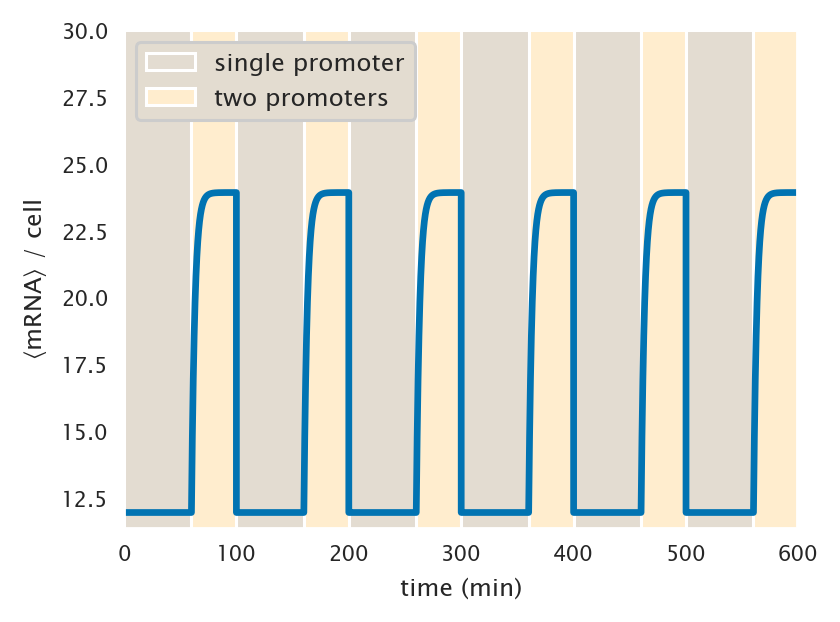

In [12]:
# Extract index for first and second moment
first_mom_names = [x for x in df_p_unreg.columns if 'm1p0' in x]

# Compute the mean mRNA copy number
m_mean = df_p_unreg.loc[:, first_mom_names].sum(axis=1)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot mean mRNA as solid line
ax.plot(df_p_unreg.time / 60, m_mean, label='', lw=2.2)

# Group data frame by cell cycle
df_group = df_p_unreg.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_p_unreg['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)

# Set limits
ax.set_xlim(df_p_unreg['time'].min() / 60, 
            df_p_unreg['time'].max() / 60)
ax.set_ylim(top=30)
# Label plot
ax.set_xlabel('time (min)')
ax.set_ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$ / cell')

ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig(figdir + 'mean_mRNA_cycles.pdf', bbox_inches='tight')

We can see from this plot that the mRNA seems to reach a steady state both when cells have one copy of the promoter, and when cells have two copies. This was expected given that the way that the mRNA production parameters were inferred in the first place assumed this steady state. This is just a confirmation that our numerical integration of the moment equations makes sense with what we expect.

It is important to highlight that we do not necessarily expect the same result for proteins since the time to steady state is set by the degradation rate, and the protein degradation rate for bacteria is assumed to be the dilution rate due to cell division.

Now let's plot the first moment. Just as before we first extract the first moments for each of the promoter states and add them together.

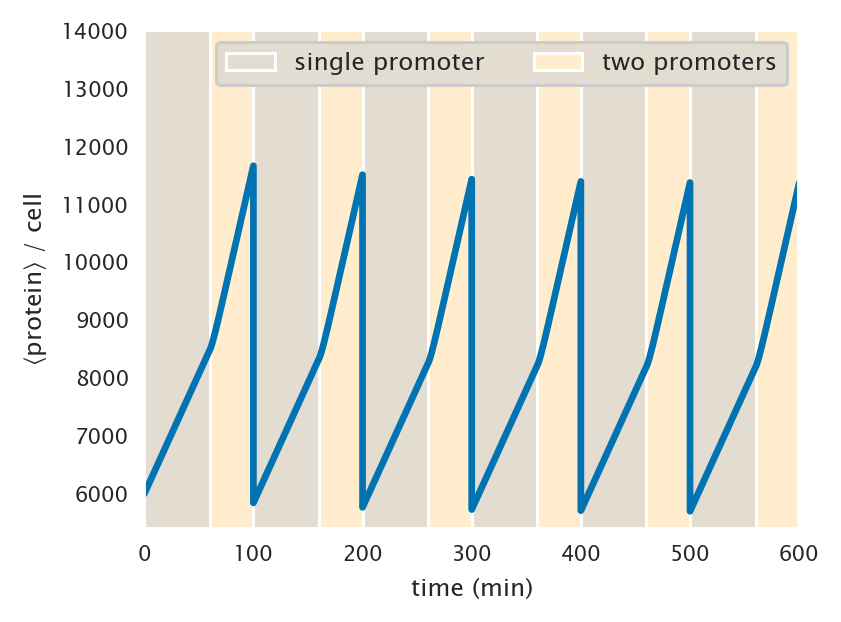

In [13]:
# Extract index for first moment
first_mom_names_m = [x for x in df_p_unreg.columns if 'm1p0' in x]
first_mom_names_p = [x for x in df_p_unreg.columns if 'm0p1' in x]

# Compute the mean mRNA copy number
m_mean = df_p_unreg.loc[:, first_mom_names_m].sum(axis=1)
p_mean = df_p_unreg.loc[:, first_mom_names_p].sum(axis=1)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot mean protein as solid line
ax.plot(df_p_unreg.time / 60, p_mean, label='', lw=2.2)

# Group data frame by cell cycle
df_group = df_p_unreg.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_p_unreg['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax.axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)

# Set limits
ax.set_xlim(df_p_unreg['time'].min() / 60, 
            df_p_unreg['time'].max() / 60)
ax.set_ylim(top=14000)
# Label plot
ax.set_xlabel('time (min)')
ax.set_ylabel(r'$\left\langle \right.$protein$\left. \right\rangle$ / cell')

ax.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.savefig(figdir + 'mean_protein_cycles.pdf', bbox_inches='tight')

For the protein case we can se that as expected the system does not reach the steady state for either of the two promoter copy numbers. What this means is that given the slower degradation rate of the protein the system doesn't have enough time to relax into the one- or two-promoter steady state.

But interestingly enough, the protein reaches some sort of "dynamic steady state" in which after several cell cycles the system reproducibly repeats the pattern of expression over and over again.

Let's plot both first moments side to side.

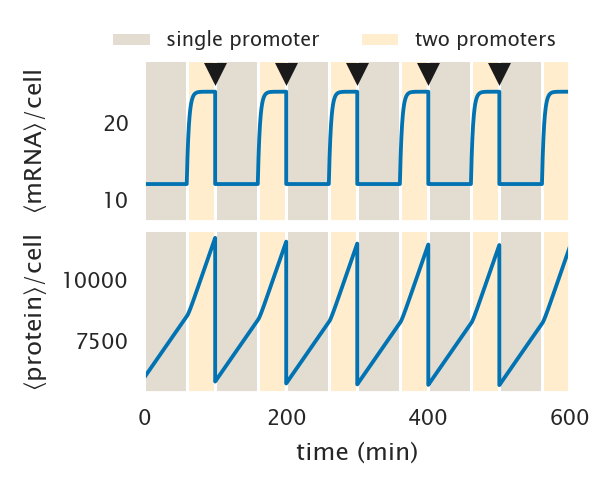

In [14]:
# Initialize figure
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2), sharex=True)

# Plot mean mRNA as solid line
ax[0].plot(df_p_unreg.time / 60, m_mean, label='', lw=1.25)
ax[1].plot(df_p_unreg.time / 60, p_mean, label='', lw=1.25)

# Group data frame by cell cycle
df_group = df_p_unreg.groupby('cycle')

# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_p_unreg['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60, 
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60, 
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label='')
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60,
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60,
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label='')

##  Indicate where the cell divisions happen
# First find where the cell cycle transition happen
trans_idx = np.array(np.diff(df_p_unreg.cycle) == 1)
# Add extra point to have same length
trans_idx = np.insert(trans_idx, 0, False)  
# Get the time points at which this happens
time_div = df_p_unreg[trans_idx].time.values
# Plot with a triangle the cell division moment
ax[0].plot(time_div / 60, [np.max(m_mean) * 1.1] * len(time_div),
           lw=0, marker='v', color='k')

# Set limits
# mRNA
ax[0].set_xlim(df_p_unreg['time'].min() / 60, df_p_unreg['time'].max() / 60)
ax[0].set_ylim([7, 28])
#protein
ax[1].set_xlim(df_p_unreg['time'].min() / 60, df_p_unreg['time'].max() / 60)

# Label plot
ax[1].set_xlabel('time (min)')
ax[0].set_ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$/cell')
ax[1].set_ylabel(r'$\left\langle \right.$protein$\left. \right\rangle$/cell')

# Align y axis labels
fig.align_ylabels()

# Set legend for both plots
ax[0].legend(loc='upper left', ncol=2, frameon=False,
             bbox_to_anchor=(-0.12, 0, 0, 1.3), fontsize=6.5)

plt.subplots_adjust(hspace=0.05)
plt.savefig(figdir + 'first_mom_cycles.pdf', bbox_inches='tight',
            transparent=True)
plt.savefig(figdir + 'first_mom_cycles.svg', bbox_inches='tight',
            transparent=True)

### Plotting mean and standard deviation.

Althoug there is no reason to believe the distributions are symmetric, it would be insightful to plot the mean $\pm$ standard deviation to see the extend of the variability. So let's go ahead and display that.

In [15]:
# Extract index for first moment
first_mom_names_m = [x for x in df_p_unreg.columns if 'm1p0' in x]
first_mom_names_p = [x for x in df_p_unreg.columns if 'm0p1' in x]

# Compute the mean mRNA copy number
m_mean = df_p_unreg.loc[:, first_mom_names_m].sum(axis=1)
p_mean = df_p_unreg.loc[:, first_mom_names_p].sum(axis=1)

# Extrac second moment
second_mom_names_m = [x for x in df_p_unreg.columns if 'm2p0' in x]
second_mom_names_p = [x for x in df_p_unreg.columns if 'm0p2' in x]

# Compute the second moments
m_second = df_p_unreg.loc[:, second_mom_names_m].sum(axis=1)
p_second = df_p_unreg.loc[:, second_mom_names_p].sum(axis=1)

# Compute variance
m_var = m_second - m_mean**2
p_var = p_second - p_mean**2

Now we are ready to plot the mean plus standard deviation.

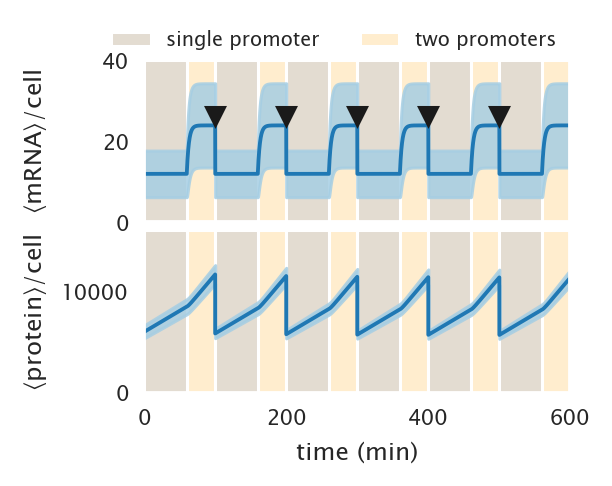

In [16]:
# Define colors
colors = sns.color_palette('Paired', n_colors=2)

# Initialize figure
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2), sharex=True)

# Plot mean as solid line
ax[0].plot(df_p_unreg.time / 60, m_mean, label='', lw=1.25,
           color=colors[1])
ax[1].plot(df_p_unreg.time / 60, p_mean, label='', lw=1.25,
           color=colors[1])

# Plot +- standard deviation 
ax[0].fill_between(df_p_unreg.time / 60, 
                   y1=m_mean + np.sqrt(m_var),
                   y2=m_mean - np.sqrt(m_var),
                   label='', color=colors[0], alpha=0.85,
                   zorder=2)
ax[1].fill_between(df_p_unreg.time / 60, 
                   y1=p_mean + np.sqrt(p_var),
                   y2=p_mean - np.sqrt(p_var),
                   label='', color=colors[0], alpha=0.85,
                   zorder=2)

# Group data frame by cell cycle
df_group = df_p_unreg.groupby('cycle')


# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_p_unreg['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60, 
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60, 
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label='')
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60,
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60,
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label='')

##  Indicate where the cell divisions happen
# First find where the cell cycle transition happen
trans_idx = np.array(np.diff(df_p_unreg.cycle) == 1)
# Add extra point to have same length
trans_idx = np.insert(trans_idx, 0, False)  
# Get the time points at which this happens
time_div = df_p_unreg[trans_idx].time.values
# Plot with a triangle the cell division moment
ax[0].plot(time_div / 60, [np.max(m_mean) * 1.1] * len(time_div),
           lw=0, marker='v', color='k')

# Set limits
# mRNA
ax[0].set_xlim(df_p_unreg['time'].min() / 60, df_p_unreg['time'].max() / 60)
ax[0].set_ylim([0, 40])
#protein
ax[1].set_xlim(df_p_unreg['time'].min() / 60, df_p_unreg['time'].max() / 60)
ax[1].set_ylim([0, 16000])

# Label plot
ax[1].set_xlabel('time (min)')
ax[0].set_ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$/cell')
ax[1].set_ylabel(r'$\left\langle \right.$protein$\left. \right\rangle$/cell')

# Align y axis labels
fig.align_ylabels()

# Set legend for both plots
ax[0].legend(loc='upper left', ncol=2, frameon=False,
             bbox_to_anchor=(-0.12, 0, 0, 1.3), fontsize=6.5)

plt.subplots_adjust(hspace=0.05)
plt.savefig(figdir + 'mean_std_cycles.png', bbox_inches='tight',
            transparent=True)

# Moment dynamics with cells exponentially distributed along cell cycle

As first discussed by Powell in 1956 populations of cells in a log-phase are exponentially distributed along the cell cycle. This distribution is of the form

$$
P(a) = (\ln 2) \cdot 2^{1 - a},
\tag{4}
$$
where $a \in [0, 1]$ is the stage of the cell cycle, with $a = 0$ being the start of the cycle and $a = 1$ being the division.

Our numerical integration of the moment equations gave us a time evolution of
the moments along the cell cycle. Without loss of generality let's focus on the
first mRNA moment $\ee{m(t)}$ (the same can be applied to all other moments).
In order to calculate the first moment along the entire cell cycle we must
average each time point by the corresponding probability that a cell is found
in such time point. This translates to computing the integral

$$
  \ee{m} = \int_{\text{beginning cell cycle}}^{\text{end cell cycle}}
                       \ee{m(t)} P(t) dt.
\tag{5}
$$

If we map each time point in the cell cycle into a fraction we can use
the distribution and compute instead

$$
  \ee{m} = \int_0^1 \ee{m(a)} P(a) da.
\tag{6}
$$

### Systematically varying the mean protein per mRNA

One thing that we need to test is how sensitive our calculations are to the chosen mean protein copy number per mRNA. For this we will compre the noise (STD / mean) over the entire cell cycel for different mean protein per mRNA values.

In [17]:
# Define mean protein / mRNA to test
mean_pm = [10, 25, 50, 100, 250, 500, 1000]

# Define number of cell cycles
n_cycles = 6

# Define names for dataframe columns
names = ['mean_pm', 'mean_p', 'second_p']
# initlaize dataframe
df_pm = pd.DataFrame(columns=names)

# Loop through mean protein per mRNA
for i, p_m in enumerate(mean_pm):
    print(p_m)
    # Define initial conditions for integration
    # Single promoter
    gp_init = 1 / (60 * 60)
    rp_init = p_m * gp_init
    # Substitute value of parameters on matrix
    ##  Initial conditions
    A_mat_unreg_s_init = A_mat_unreg_lam(param['kp_on'], param['kp_off'],
                                         param['rm'], param['gm'], 
                                         rp_init, gp_init)
    # Define time on which to perform integration
    t = np.linspace(0, 4000 * 60, 2000)

    # Define initial conditions
    mom_init = np.zeros(len(expo) * 2)
    # Set initial condition for zero moment
    # Since this needs to add up to 1
    mom_init[0] = 1

    # Numerically integrate equations
    mp_sol = sp.integrate.odeint(dmomdt, mom_init, t, 
                                 args=(A_mat_unreg_s_init,))

    mp_init = mp_sol[-1, :]
    
    # Find protein production rate
    rp_opt = sp.optimize.minimize_scalar(rp_residual, 
                                     bounds=(0, 0.1), method='bounded',
                                     args=(mp_init, p_m))

    # Extract parameter
    rp = rp_opt.x
    

    # Define list of parameters
    par_single = [param['kp_on'], param['kp_off'], param['rm'], param['gm'],
              rp, 0]
    par_double = [param['kp_on'], param['kp_off'], 2 * param['rm'],
              param['gm'], rp, 0]

    # Integrate moment equations
    df_p_unreg = dmomdt_cycles(mp_init, t_single, t_double, 
                               A_mat_unreg_lam, 
                               par_single, par_double, expo,
                               n_cycles, Z_mat, n_steps=10000)

    # Extract index for protein first moment
    first_mom_names_p = [x for x in df_p_unreg.columns if 'm0p1' in x]

    # Extract the last cycle information
    df_p_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == 
                                      df_p_unreg.cycle.max(),
                                      first_mom_names_p]
    
    # Extract index for protein second moment
    second_mom_names_p = [x for x in df_p_unreg.columns if 'm0p2' in x]
    
    # Extract the last cycle information
    df_p_unreg_second = df_p_unreg.loc[df_p_unreg.cycle == 
                                      df_p_unreg.cycle.max(),
                                      second_mom_names_p]
    
    # Extract time of last cell cycle
    time = np.sort(df_p_unreg.loc[df_p_unreg.cycle == 
                                  df_p_unreg.cycle.max(),
                                  'time'].unique())

    # Compute the time differences
    time_diff = np.diff(time)

    # Compute the cumulative time difference
    time_cumsum = np.cumsum(time_diff)
    time_cumsum = time_cumsum / time_cumsum[-1]

    # Define array for spacing of cell cycle
    a_array = np.zeros(len(time))
    a_array[1:] = time_cumsum 

    # Compute probability based on this array
    p_a_array = np.log(2) * 2**(1 - a_array)

    # Perform numerical integration
    p_mean = sp.integrate.simps(df_p_unreg_first.sum(axis=1) * p_a_array,
                                      a_array)
    p_second = sp.integrate.simps(df_p_unreg_second.sum(axis=1) * 
                                        p_a_array, a_array)
    
    # Save results on pandas Series
    series = pd.Series([p_m, p_mean, p_second], index=names)
    # Append to dataframe
    df_pm = df_pm.append(series, ignore_index=True)

10
25
50
100
250
500
1000


Having run the dynamics let's compute the noise

(0, 0.25)

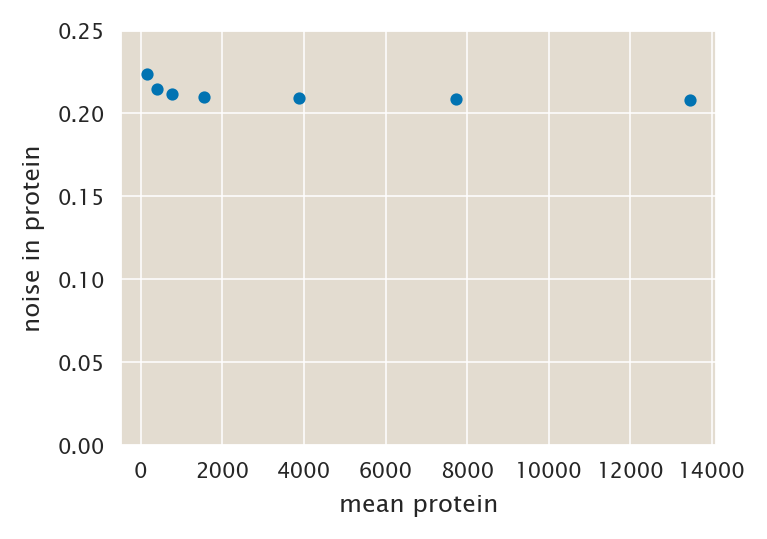

In [18]:
# Compute variance deviation
df_pm['var_p'] = df_pm['second_p'] - df_pm['mean_p']**2

# Compute the standard deviation
df_pm['std_p'] = np.sqrt(df_pm['var_p'])

# Compute the noise
df_pm['noise_p'] = df_pm['std_p'] / df_pm['mean_p']

plt.plot(df_pm['mean_p'], df_pm['noise_p'], '.')
plt.xlabel('mean protein')
plt.ylabel('noise in protein')
plt.ylim([0, 0.25])

These values seem pretty robust. So at the level of the noise there is not a significant difference with the amount of protein production.

## Three-state promoter

Let's now include the regulation given by the repressor. For this we change to the three-state promoter that includes two new parameters $\kron$ and $\kroff$. At the mRNA level by assumption our parameter inference assumed that the promoter quickly relaxed from the steady state with one promoter to the steady state with two promoters. This is clearly reflected in the dynamics as we saw in the previous section. Therefore, if we ignore the transients between the single promoter and the two promoters state, the fold-change is of the form. 

$$
\foldchange = 
{ f \cdot \ee{m(R \neq 0)}_1 + (1 - f) \cdot \ee{m(R \neq 0)}_2
\over
f \cdot \ee{m(R = 0)}_1 + (1 - f) \cdot \ee{m(R = 0)}_2},
\tag{7}
$$
where $f \in [0, 1]$ is the fraction of the cell cycle that cells spend with a single copy of the promoter.

Just as our reporter gene changes in copy number and therefore the protein copy number changes along the cell cycle we expect the repressor copy number itself to vary as cells grow and divide. We simplify this picture and assume that the experimentally determined repressor copy number is an effective parameter that remains unchanged along the cell cycle. What that means for our model is that $\kron$ doesn't change along the cell cycle. This is obviously an approximation and only the numerical test of this assumption will tell us how much it affects the theoretical predictions. Under this assumption it can be shown that the fold-change can be simplified to

$$
\foldchange = \left( 1 + {\kron \over \kroff} \left( {\kpon \over \kpon + \kpoff} \right) \right)^{-1}.
\tag{8}
$$
We can then use the fact that the functional form is exactly the same as the thermodynamic fold-change to constraint the value of the $\kron \over \kroff$ ratio.

Working with this let's compute the fold-change using this kinetic model.

### LacI titration

To compare the results from the kinetic and the equilibrium model we need to compute the mRNA and protein first moment averaged over the entire cell cycle. We will do this by performing the integral explained in the previous section.

We must now import the matrix $\bb{A}$ for the three-state regulated promoter.

In [19]:
# Read protein ununregulated matrix 
with open('./pkl_files/three_state_protein_dynamics_matrix.pkl', 'rb') as file:
    A_mat_reg_lam = cloudpickle.load(file)
    expo_reg = cloudpickle.load(file)

Now let's compute the fold-change for different operators and different repressor copy numbers updating the repressor rates $\kron$ and $\kroff$ at each iteration.

We can visualize these results by ploting the fold-change in gene expression as a function of repressor copy number in a log-log plot.

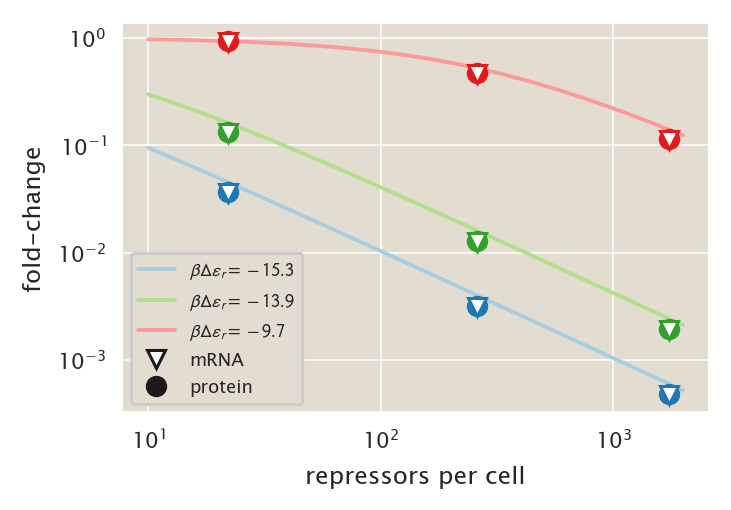

In [22]:
# Define range of repressors for which compute the thermo fold-change
r_array = np.logspace(1, np.log10(2000), 50)

# Group data frame by operator
df_group = df_fc_p.groupby('energy')

# Define colors
colors = sns.color_palette('Paired', n_colors=len(df_group) * 2)

# Loop through operator
for i, (group, data) in enumerate(df_group):
    # Compute thermo fold-change
    fold_change_thermo =  (1 + r_array / param['Nns'] * np.exp(- group))**-1

    # Plot thermodynamic fold-change prediction
    plt.plot(r_array, fold_change_thermo,
    label=fr'$\beta\Delta\epsilon_r = {data.energy.unique()[0]}$',
             color=colors[i * 2])
    # Plot the kinetic fold-change prediciton
    # Protein
    plt.plot(data.repressors.values, data.fold_change_p.values,
             lw=0, marker='o', 
             color=colors[(i * 2) + 1], label='')
    # mRNA
    plt.plot(data.repressors.values, data.fold_change_m.values,
             lw=0, marker='v', 
             markeredgecolor=colors[(i * 2) + 1], markeredgewidth=1,
             markerfacecolor='w', label='')

# Generate labels for mRNA and protein
plt.plot([], [], lw=0, marker='v', 
         markeredgecolor='k', markeredgewidth=1,
         markerfacecolor='w', label='mRNA')
plt.plot([], [], lw=0, marker='o', 
         color='k', label='protein')

# Change scale to log
plt.xscale('log')
plt.yscale('log')

# Label axis
plt.xlabel('repressors per cell')
plt.ylabel('fold-change')

# Set legend
plt.legend(fontsize=6)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'lacI_titration.pdf', bbox_inches='tight')

The small deviations between the kinetic and the thermodynamic picture come from the fact that the parameters as determined assume that the mRNA reaches steady state for both the single- and the double-promoter state, ignoring the changes in repressor copy number as the cell cycle progresses for example. But these deviations are within our experimental resolution, so the approximation seems to do a good job.

### IPTG titration 

Now that we know that the rates are able to reproduce the equilibrium picture of the LacI titration (up to a systematic deviation) let's complete the analysis of the equivalence between both frameworks by including the effect of the inducer.  For this analysis we will keep the operator fix and vary both the repressor copy number and the IPTG concentration.

In [25]:
# repressor-DNA binding energy
op = 'O2'
eRA = -13.9 # kBT

# Define repressor copy number list
rep_array = [22, 260, 1740] # repressors per cell

# Define IPTG concentrations
iptg_array = [0, 0.1, 5, 10, 25, 50, 75, 100, 500, 1000] # µM

# Initialize data frame to save fold-changes
names = ['operator', 'energy', 'repressors', 'iptg_uM',
         'mean_m_reg', 'mean_m_unreg', 'fold_change_m',
         'mean_p_reg', 'mean_p_unreg', 'fold_change_p']
df_fc_iptg = pd.DataFrame(columns=names)

# Loop through operators
for j, iptg in enumerate(iptg_array):
    print(iptg)
    # Loop through repressor copy numbers
    for i, rep in enumerate(rep_array):
        # Define parameters
        eRA = param[f'epR_{op}']
        kp_on = param['kp_on']
        kp_off = param['kp_off']
        kr_off = param['kr_off_O2']
        ko = param['k0']
        rm = param['rm']
        gm = param['gm']
        rp = param['rp']
        ka = param['Ka']
        ki = param['Ki']
        epAI = param['epAI']
        
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * ccutils.model.p_act(iptg, ka, ki, epAI) 

        # Generate matrices for dynamics
        # Single promoter
        par_reg_s = [kr_on, kr_off, kp_on, kp_off, rm, gm, rp, 0]
        # Two promoters
        par_reg_d = [kr_on, kr_off, kp_on, kp_off, 2 * rm, gm, rp, 0]
        
        # Initial conditions
        A_reg_s_init = A_mat_reg_lam(kr_on, kr_off, kp_on, kp_off, 
                                   rm, gm, rp_init, gp_init)

        # Define initial conditions
        mom_init = np.zeros(len(expo_reg) * 3)
        # Set initial condition for zero moment
        # Since this needs to add up to 1
        mom_init[0] = 1
        
        # Define time on which to perform integration
        t = np.linspace(0, 4000 * 60, 10000)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(dmomdt, mom_init, t, 
                                     args=(A_reg_s_init,))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = dmomdt_cycles(m_init, t_single, t_double,
                           A_mat_reg_lam, 
                           par_reg_s, par_reg_d,
                           expo_reg, n_cycles, Z_mat,
                           states=['A', 'I', 'R'], 
                           n_steps=3000)

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Extract index for first moment
        first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
        first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

        # Extract the last cycle information of the first moments
        df_m_reg_first = df.loc[:, first_mom_names_m]
        df_p_reg_first = df.loc[:, first_mom_names_p]
        
        # Extract time of last cell cycle
        time = np.sort(df['time'].unique())

        # Compute the time differences
        time_diff = np.diff(time)
        # Compute the cumulative time difference
        time_cumsum = np.cumsum(time_diff)
        time_cumsum = time_cumsum / time_cumsum[-1]

        # Define array for spacing of cell cycle
        a_array = np.zeros(len(time))
        a_array[1:] = time_cumsum 
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Perform numerical integration
        m_mean_reg = sp.integrate.simps(df_m_reg_first.sum(axis=1) * p_a_array,
                                          a_array)
        p_mean_reg = sp.integrate.simps(df_p_reg_first.sum(axis=1) * p_a_array,
                                          a_array)

        # Compute the fold-change
        fold_change_m = m_mean_reg / m_mean_unreg
        fold_change_p = p_mean_reg / p_mean_unreg
        
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, rep, iptg,
                            m_mean, m_mean_unreg, fold_change_m,
                            p_mean, p_mean_unreg, fold_change_p],
                           index=names)
        
        df_fc_iptg = df_fc_iptg.append(series, ignore_index=True)

0
0.1
5
10
25
50
75
100
500
1000


Let's plot the inducer titration to compare the predictions done by the equilibrium picture and the kinetic model with this new variation.

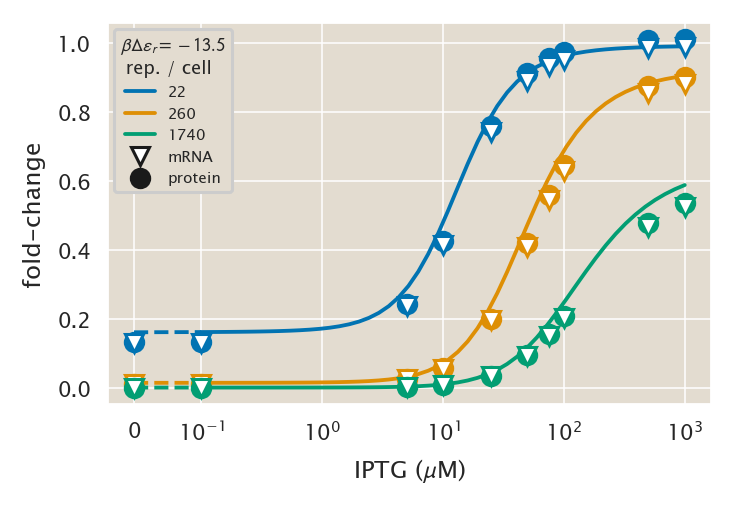

In [28]:
# Define IPTG range to compute thermodynamic fold-change
iptg = np.logspace(-1, 3, 50)
iptg_lin = [0, 0.1]

# Group data frame by repressor copy number
df_group = df_fc_iptg.groupby('repressors')

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Loop through each of the repressor copy numbers
for i, (rep, data) in enumerate(df_group):
    Nns = param['Nns']
    # Compute thermodynamic fold-change
    fc_thermo = (1 + rep / Nns * ccutils.model.p_act(iptg, ka, ki, epAI) *
                 np.exp(- data.energy.unique()[0]))**-1
    fc_thermo_lin = (1 + rep / Nns * ccutils.model.p_act(iptg_lin, 
                                                         ka, ki, epAI) *
                 np.exp(- data.energy.unique()[0]))**-1
    
    # Plot thermodynamic fold-change prediction
    plt.plot(iptg, fc_thermo, label=str(rep), color=colors[i])
    plt.plot(iptg_lin, fc_thermo_lin, label='', color=colors[i],
             linestyle='--')
    
    # Plot the kinetic fold-change prediciton
    # Protein
    plt.plot(data.iptg_uM.values, data.fold_change_p.values, lw=0, marker='o', 
             color=colors[i], label='')
    # mRNA
    plt.plot(data.iptg_uM.values, data.fold_change_m.values, lw=0, marker='v', 
             markeredgecolor=colors[i], markeredgewidth=1,
             markerfacecolor='w', label='')

# Generate labels for mRNA and protein
plt.plot([], [], lw=0, marker='v', 
         markeredgecolor='k', markeredgewidth=1,
         markerfacecolor='w', label='mRNA')
plt.plot([], [], lw=0, marker='o', 
         color='k', label='protein')
    
# Change scale to log
plt.xscale('symlog', linthreshx=1E-1, linscalex=0.5)

# Label axis
plt.xlabel(r'IPTG ($\mu$M)')
plt.ylabel('fold-change')

# Set legend
legend = plt.legend(title=r'$\beta\Delta\epsilon_r =  -13.5$' '\n rep. / cell',
                    fontsize=5)
plt.setp(legend.get_title(),fontsize=6)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'IPTG_titration.pdf', bbox_inches='tight')

This again looks pretty good. It seems that at the level of mean gene expression the kinetic model can reproduce the predictions made by the thermodynamic model.

## Systematic moment computation

Now that we confirmed that these parameters can reproduce the equilibrium picture let's systematically obtain average moments for varying repressor copy numbers, operators and inducer concentrations that later on we will use to compute the maximum entropy approximation of the distribution.

We will generate and export a tidy data frame containing all moments.

### Varying IPTG concenrations, experimental repressor copy number.

On a separate script `src/theory/scripts/mdcd_iptg_range.py` we compute the moments for a fine grid of IPTG concentrations. Here we will just load the resulting tidy data frame.

In [30]:
df_mom_iptg = pd.read_csv(datadir + 
                                  'MaxEnt_multi_prom_IPTG_range.csv')
df_mom_iptg.head()

,operator,binding_energy,repressor,inducer_uM,m0p0,m1p0,m2p0,m3p0,m4p0,m5p0,...,m3p2,m2p3,m1p4,m0p5,m5p1,m4p2,m3p3,m2p4,m1p5,m0p6
0,O1,-15.3,0,0.000000,1.000001,15.46507,322.675729,8592.936386,278504.362303,1.054893e+07,...,7.435490e+11,2.400384e+14,9.106554e+16,4.227172e+19,1.023094e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007275e+23
1,O1,-15.3,0,0.100000,1.000001,15.46507,322.675729,8592.936386,278504.362303,1.054893e+07,...,7.435490e+11,2.400384e+14,9.106554e+16,4.227172e+19,1.023094e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007275e+23
2,O1,-15.3,0,0.125284,1.000001,15.46507,322.675729,8592.936386,278504.362303,1.054893e+07,...,7.435490e+11,2.400384e+14,9.106554e+16,4.227172e+19,1.023094e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007275e+23
3,O1,-15.3,0,0.156961,1.000001,15.46507,322.675729,8592.936386,278504.362303,1.054893e+07,...,7.435490e+11,2.400384e+14,9.106554e+16,4.227172e+19,1.023094e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007275e+23
4,O1,-15.3,0,0.196646,1.000001,15.46507,322.675729,8592.936386,278504.362303,1.054893e+07,...,7.435490e+11,2.400384e+14,9.106554e+16,4.227172e+19,1.023094e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007275e+23


### Varying number of repressors, 12 IPTG concentrations.

As in the previous case a separate script `src/theory/scripts/mdcd_repressor_range.py` we compute the moments for a fine grid of IPTG concentrations. Here we will just load the resulting tidy data frame.

In [32]:
df_mom_rep = pd.read_csv(datadir + 
                         'MaxEnt_multi_prom_constraints.csv')
df_mom_rep.head()

,operator,binding_energy,repressor,inducer_uM,m0p0,m1p0,m2p0,m3p0,m4p0,m5p0,...,m3p2,m2p3,m1p4,m0p5,m5p1,m4p2,m3p3,m2p4,m1p5,m0p6
0,O1,-15.3,0.0,0.0,1.000001,15.46507,322.675729,8592.936386,278504.362303,1.054893e+07,...,7.435490e+11,2.400384e+14,9.106554e+16,4.227172e+19,1.023094e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007275e+23
1,O1,-15.3,0.0,0.1,1.000001,15.46507,322.675729,8592.936386,278504.362303,1.054893e+07,...,7.435490e+11,2.400384e+14,9.106554e+16,4.227172e+19,1.023094e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007275e+23
2,O1,-15.3,0.0,5.0,1.000001,15.46507,322.675729,8592.936386,278504.362303,1.054893e+07,...,7.435490e+11,2.400384e+14,9.106554e+16,4.227172e+19,1.023094e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007275e+23
3,O1,-15.3,0.0,10.0,1.000001,15.46507,322.675729,8592.936386,278504.362303,1.054893e+07,...,7.435490e+11,2.400384e+14,9.106554e+16,4.227172e+19,1.023094e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007275e+23
4,O1,-15.3,0.0,25.0,1.000001,15.46507,322.675729,8592.936386,278504.362303,1.054893e+07,...,7.435490e+11,2.400384e+14,9.106554e+16,4.227172e+19,1.023094e+11,2.564953e+13,7.223464e+15,2.324187e+18,8.751674e+20,4.007275e+23


## Comparing constraints with single-promoter model.

An interesting question is how we expect the moments to change with respect to a kinetic model in which the variability in gene copy number along the cell cycle is ignored.

### Noise

Let's now look at the noise defined as

$$
\text{noise} \equiv {\text{STD}(X) \over \ee{X}},
\tag{9}
$$
where $\text{STD}(x)$ is the standard deviation of the random variable $X$. The reason for choosing this metric over the commonly used Fano factor is that when quantified from experimental data this is a dimensionless quantity that can be directly inferred from arbitrary units of fluorescence as long as there is a linear relationship between these arbitrary units and the absolute molecule count.

The expectation here is that since having multiple promoters increases the variability over the cell cycle, the multi-promoter model should have a higher noise.

Let's first compute this quantity along with the fold-change for both the mRNA and protein level

In [33]:
# Read constraints for the single promoter model
df_mom_single = pd.read_csv(datadir + 'single_prom_moments.csv')

# Find the mean unregulated levels to compute the fold-change
mean_m_delta = np.mean(
    df_mom_iptg[df_mom_iptg.repressor==0].m1p0
)
mean_p_delta = np.mean(
    df_mom_iptg[df_mom_iptg.repressor==0].m0p1
)

# Compute the noise for the multi-promoter data
df_mom_iptg = df_mom_iptg.assign(
    m_noise=np.sqrt(df_mom_iptg.m2p0 - df_mom_iptg.m1p0**2) / 
            df_mom_iptg.m1p0,
    p_noise=np.sqrt(df_mom_iptg.m0p2 - df_mom_iptg.m0p1**2) / 
            df_mom_iptg.m0p1,
    m_fold_change=df_mom_iptg.m1p0 / mean_m_delta,
    p_fold_change=df_mom_iptg.m0p1 / mean_p_delta
)

Now let's plot the noise for the regulated case. We will show the difference between the single and the multiple promoter model for different operators (repressor-DNA binding energy) and varying repressor copy numbers.

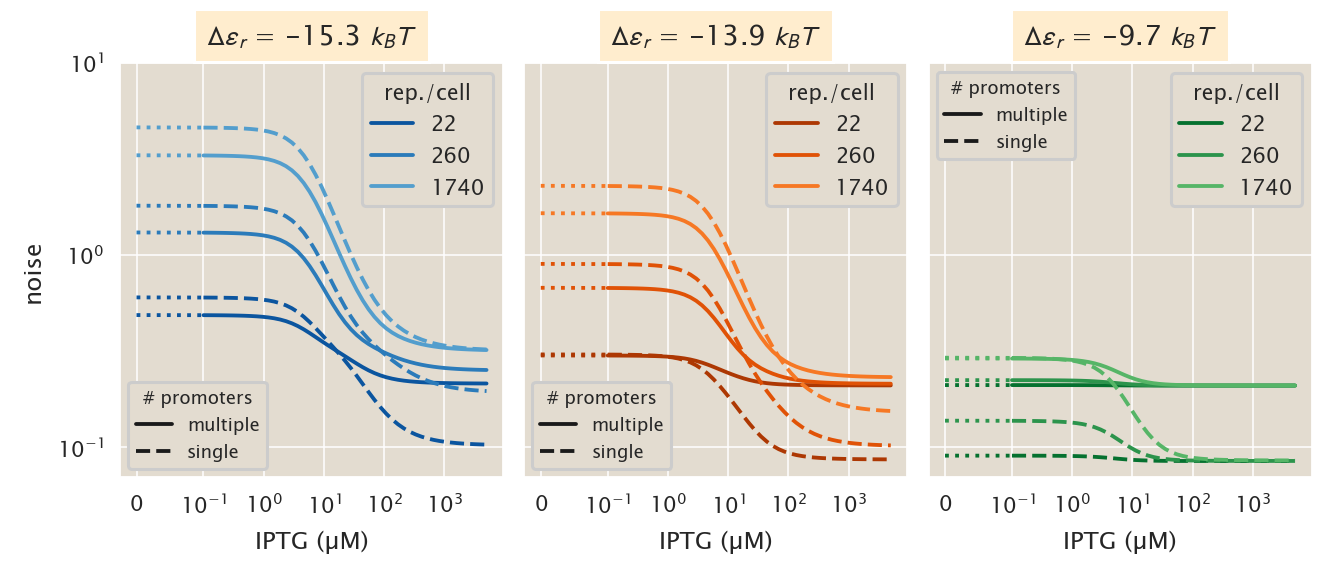

In [36]:
# Define repressor copy numbers to include
rep = [22, 260, 1740]

# Group moments by operator and repressor
df_group = df_mom_iptg[df_mom_iptg['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])

df_group_single = df_mom_single[df_mom_single['repressor'].\
                  isin(rep)].sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Define energies to go along operators
energies = [-15.3, -13.9, -9.7]

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i],
                                 n_colors=len(rep) + 3)[0:3]))

# Define threshold to separate linear from logarithmic scale
thresh = 1E-1

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), sharex=True, sharey=True)

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Log scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                              data[data.inducer_uM >= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    # linear scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                              data[data.inducer_uM <= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')

# Loop through groups on single-promoter
for i, (group, data) in enumerate(df_group_single):
    # Log scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                              data[data.inducer_uM >= thresh].p_noise, 
                              linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='', alpha=1)
    # Linear scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                              data[data.inducer_uM <= thresh].p_noise, 
                              linestyle=':',
                              color=col_dict[group[0]][group[1]],
                              label='', alpha=1)

# Define location for secondary legend
leg2_loc = ['lower left'] * 2 + ['upper left']
for i, a in enumerate(ax):
    # Generate legend for single vs double promoter
    single, = ax[i].plot([], [], color='k', linestyle='--', label='',
               alpha=1)
    multi, = ax[i].plot([], [], color='k', label='')
    # systematically change axis for all subplots
    ax[i].set_xscale('symlog', linthreshx=1E-1, linscalex=1)
    ax[i].set_yscale('log')
    ax[i].set_ylim(top=10)
    # Set legend
    leg1 = ax[i].legend(title='rep./cell', fontsize=7, loc='upper right')
    # Set legend font size
    plt.setp(leg1.get_title(), fontsize=7)
    # leg1 will be removed from figure
    leg2 = ax[i].legend([multi, single], ['multiple', 'single'],
                        loc=leg2_loc[i],
                        fontsize=6, title='# promoters')
    # Set legend font size
    plt.setp(leg2.get_title(), fontsize=6)
    # Manually add the first legend back
    ax[i].add_artist(leg1)
 
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    # Label axis
    ax[i].set_xlabel(r'IPTG (µM)')
ax[0].set_ylabel(r'noise')

# Change spacing between plots
plt.subplots_adjust(wspace=0.05)

plt.savefig(figdir + 'noise_comparison.pdf', bbox_inches='tight')

We can see that there is a striking difference between both models, especially at high inducer concentrations. This shows that there is a significant amount of cell-to-cell variability that comes from the gene copy number variability and the non-steady-state dynamics of the moments according to the model.

## Comparison with experimental data

In order to assess if our dynamical theory for the moments works we will compare experimentally determined moments to our theoretical predictions. For this we need to read the microscopy data gathered so far.

In [38]:
# Read the tidy-data frame
files = glob.glob('../../data/csv_microscopy/*IPTG*csv')# + mwc_files
df_micro = pd.concat([pd.read_csv(f, comment='#') 
                      for f in files if 'Oid' not in f], sort=True)

# Remove data sets that are ignored because of problems with 
# the data quality
# NOTE: These data sets are kept in the repository for transparency, but they
# failed at one of our quality criteria
# (see README.txt file in microscopy folder)
ignore_files = [x for x in os.listdir('../image_analysis/ignore_datasets/')
                if 'microscopy' in x]
# Extract data from these files
ignore_dates = [int(x.split('_')[0]) for x in ignore_files]

# Remove these dates
df_micro = df_micro[~df_micro['date'].isin(ignore_dates)]

df_micro[['date', 'operator', 'rbs', 'mean_intensity', 'intensity']].head()

,date,operator,rbs,mean_intensity,intensity
0,20181018,O2,auto,88.876915,502.830035
1,20181018,O2,auto,99.759342,393.291230
2,20181018,O2,auto,94.213193,552.315421
3,20181018,O2,auto,92.993102,426.131591
4,20181018,O2,auto,94.591855,455.251678


Consider that the noise is defined as

\begin{equation}
\text{noise} \equiv \frac{\sqrt{\left\langle p^2 \right\rangle - \left\langle p \right\rangle^2}}{\left\langle p \right\rangle}.
\tag{10}
\end{equation}
Assume that the intensity level of a cell $I$ is linearly proportional to the absolute protein count, i.e.

$$
I = \alpha p,
\tag{11}
$$
where $\alpha$ is the proportionality constant between arbitrary units (a.u.) and protein count. Substituting this definition on the noise gives

\begin{equation}
\text{noise} = {\sqrt{\left\langle (\alpha I)^2 \right\rangle - 
                   \left\langle \alpha I \right\rangle^2} \over 
                   \left\langle \alpha I \right\rangle}.
\tag{12}
\end{equation}
Since $\alpha$ is a constant it can be taken out of the average operator $\ee{\cdot}$, obtaining

\begin{equation}
\text{noise} = {\sqrt{\alpha^2 \left(\left\langle I^2 \right\rangle - 
              \left\langle I \right\rangle^2 \right)} \over 
              \alpha \left\langle  I \right\rangle}
     = {\sqrt{\left(\left\langle I^2 \right\rangle - 
              \left\langle I \right\rangle^2 \right)} \over 
              \left\langle  I \right\rangle}
\tag{13}
\end{equation}

The proportionality between intensity and protein count has no intercept. This ignores the autofluorescence that cells without
reporter would generate. Therefore in practice to compute the noise from experimental intensity measurements we compute

\begin{equation}
\text{noise} = \frac{\sqrt{\left\langle (I  - \langle I_{\text{auto}}\rangle)^2 \right\rangle - \left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle^2}}{\left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle},
\tag{14}
\end{equation}
where $I$ is the intensity of the objective strain and $\langle I_{\text{auto}}\rangle$ is the mean autofluorescence intensity.

Having shown that this quantity is dimensionless we can therefore compare the experimentally determined noise with our theoretical predictions. Let's begin with the unregulated promoter.

### Unregulated promoter

Let's first take the intensity measurements of the $\Delta lacI$ strains and compute the noise.

In [82]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Define names for columns in data frame
names = ['date', 'IPTG_uM','operator', 'binding_energy',
        'rbs', 'repressors', 'mean', 'std', 'noise']

# Initialize data frame to save the noise
df_noise_delta = pd.DataFrame(columns=names)
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[data.rbs == 'delta']
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Extract areas of cells
        areas = data_inducer.area
        # Append the require info
        strain_info = [
            date,
            inducer,
            data_inducer.operator.unique()[0],
            data_inducer.binding_energy.unique()[0],
            data_inducer.rbs.unique()[0],
            data_inducer.repressors.unique()[0],
            (data_inducer.intensity - I_auto * areas).mean(), 
            (data_inducer.intensity - I_auto * areas).std(ddof=1)]
        # Check if the values are negative for very small noise
        if strain_info[int(np.where(np.array(names) == 'mean')[0])] > 0:
            # Compute the noise
            strain_info.append(strain_info[-1] / strain_info[-2])
            # Convert to a pandas series to attach to the dataframe
            strain_info = pd.Series(strain_info, index=names)
            # Append to the info to the data frame
            df_noise_delta = df_noise_delta.append(strain_info, 
                                                   ignore_index=True)
    
df_noise_delta.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise
0,20161203,0.0,O2,-13.9,delta,0,18005.503591,6694.179728,0.371785
1,20180326,0.0,O2,-13.9,delta,0,8880.058753,3819.106971,0.430077
2,20180326,5000.0,O2,-13.9,delta,0,10548.109493,3379.513991,0.320390
3,20180327,0.0,O3,-9.7,delta,0,11364.484449,5630.115523,0.495413
4,20180327,5000.0,O3,-9.7,delta,0,9839.249978,3496.403081,0.355353


Now let's plot the noise for each of the operators along with the theoretical prediction for the multi-promoter model. In principle there shouldn't be any difference between operators since these are all unregulated promoters. But it it known that basepairs downstream the RNAP binding site can affect transcriptional output as well. We ignore this in the model, but to make sure here we will plot each $\Delta lacI$ strain separatade by operators.

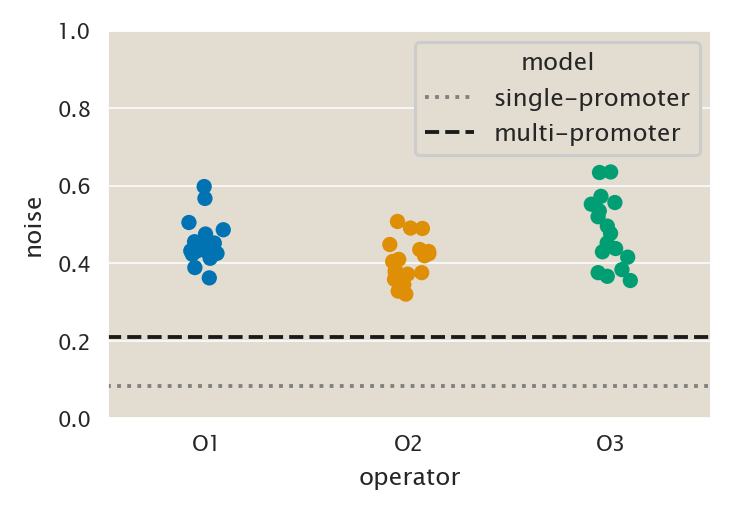

In [83]:
# Extract theoretical noise for the ∆lacI strain
noise_delta_thry = df_mom_iptg[
    df_mom_iptg.repressor == 0
].p_noise.mean()
noise_delta_thry_single = df_mom_single[
    df_mom_single.repressor == 0
].p_noise.mean()

# Initialize figure
fig = plt.figure()

# Define colors for operators
col_list = ['Blues_r', 'Reds_r', 'Greens_r']
colors = [sns.color_palette(x, n_colors=1) for x in col_list]

# Plot theoretical prediction

# Generate stripplot for experimentally determined 
# noise of the ∆lacI strain
sns.stripplot(x='operator', y='noise',
            order=['O1', 'O2', 'O3'], data=df_noise_delta)

# Plot theoretical prediction as a horizontal black line
plt.axhline(noise_delta_thry_single, color='gray', linestyle=':',
            label='single-promoter')
plt.axhline(noise_delta_thry, color='k', linestyle='--',
            label='multi-promoter')

# Include legend
plt.legend(title='model')

# Set axis limits
plt.ylim([0, 1])

# Label axis
plt.ylabel(r'noise')

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'noise_delta_microscopy.pdf', bbox_inches='tight')

The prediction are not entirely correct for either model. But the multi-promoter model is a little closer to the data.

### Regulated promoter

Let's extend the analysis to the regulated promoter. Again we will take the single-cell intensity measurements, extract the auto fluorescence and compute the noise.

We will also compute the fold-change with respect to the unregulated promoter since later on we will compare these two predictions - noise and fold-change - side to side.

In [84]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Define names for columns of data frame
names = ['date', 'IPTG_uM','operator', 'binding_energy',
         'rbs', 'repressors', 'mean', 'std', 'noise', 'fold_change']
# Initialize data frame to save the noise
df_noise = pd.DataFrame(columns=names)
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]
    
    # Obtain the unregulated mean expression to compute
    # the fold-change
    mean_delta = np.mean(df_noise_delta[df_noise_delta.date == date]['mean'])
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Extract cell areas
        areas = data_inducer.area
        # Append the require info
        strain_info = [
            date,
            inducer,
            data_inducer.operator.unique()[0],
            data_inducer.binding_energy.unique()[0],
            data_inducer.rbs.unique()[0],
            data_inducer.repressors.unique()[0],
            (data_inducer.intensity - I_auto * areas).mean(), 
            (data_inducer.intensity - I_auto * areas).std(ddof=1)]
        # Check if the values are negative for very small noise
        if strain_info[int(np.where(np.array(names) == 'mean')[0])] > 0:
            # Compute the noise
            strain_info.append(strain_info[-1] / strain_info[-2])
            # Compute fold-change
            strain_info.append(strain_info[
            int(np.where(np.array(names) == 'mean')[0])] / mean_delta)
            # Convert to a pandas series to attach to the dataframe
            strain_info = pd.Series(strain_info, index=names)
            # Append to the info to the data frame
            df_noise = df_noise.append(strain_info, ignore_index=True)
    
df_noise = df_noise.sort_values('repressors')
df_noise.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise,fold_change
321,20190626,0.0,O2,-13.9,HG104,22,4513.870003,2319.828027,0.513933,0.258308
223,20181018,1000.0,O2,-13.9,HG104,22,6711.766492,3177.392763,0.473406,0.975183
224,20181018,5000.0,O2,-13.9,HG104,22,6418.342436,2891.501715,0.450506,0.932550
225,20181025,0.0,O2,-13.9,HG104,22,1749.505194,882.929653,0.504674,0.184602
94,20180412,5000.0,O1,-15.3,HG104,22,13927.764491,5458.278639,0.391899,1.082215


Let's now plot the noise as a function of the IPTG concentration for all strains measured experimentally. Here we will show with a solid line the predictions made by the model that accoutns for gene copy number variability during the cell cycle, and with a dotted line the predictions for the single promoter model.

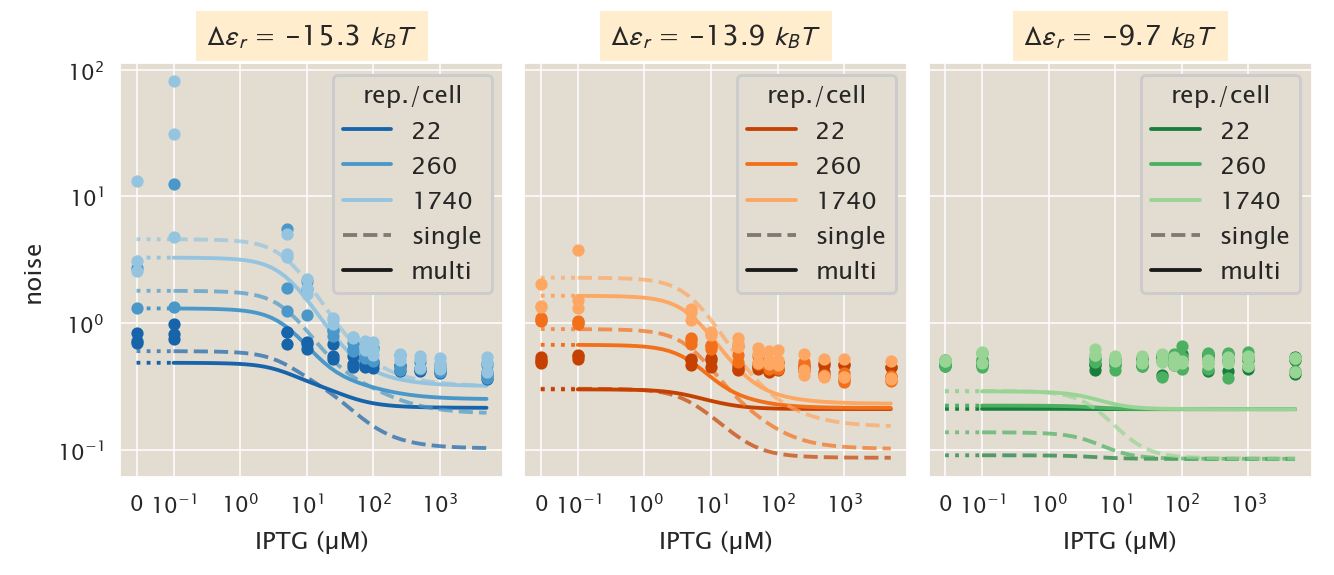

In [85]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[df_noise.noise > 0].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_mom_iptg[df_mom_iptg['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])
df_group_single = df_mom_single[df_mom_single['repressor'].\
                  isin(rep)].sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i],
                                 n_colors=len(rep) + 1)[0:3]))

# Define threshold to separate linear from log scale
thresh = 1E-1

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), sharex=True, sharey=True)

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Log scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                              data[data.inducer_uM >= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    # linear scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                              data[data.inducer_uM <= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')

# Loop through groups on single-promoter
for i, (group, data) in enumerate(df_group_single):
    # Log scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                              data[data.inducer_uM >= thresh].p_noise, 
                              linestyle='--',
                              alpha=0.7,
                              color=col_dict[group[0]][group[1]],
                              label='')
    # Linear scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                              data[data.inducer_uM <= thresh].p_noise, 
                              linestyle=':',
                              alpha=0.7,
                              color=col_dict[group[0]][group[1]],
                              label='')

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    ax[op_idx[group[0]]].plot(data.IPTG_uM, data.noise, linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=3)


for i, a in enumerate(ax):
    # Generate legend for single vs double promoter
    ax[i].plot([], [], color='k', linestyle='--', label='single',
               alpha=0.5)
    ax[i].plot([], [], color='k', label='multi')
    # systematically change axis for all subplots
    ax[i].set_xscale('symlog', linthreshx=thresh, linscalex=0.5)
    ax[i].set_yscale('log')
    # Set legend
    leg = ax[i].legend(title='rep./cell', fontsize=8)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=8)
 
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    # Label axis
    ax[i].set_xlabel(r'IPTG (µM)')
ax[0].set_ylabel(r'noise')

# Change spacing between plots
plt.subplots_adjust(wspace=0.05)

# plt.tight_layout()
plt.savefig(figdir + 'noise_comparison_exp.pdf', bbox_inches='tight')

The predictions from the multi-promoter model are very good except for some of the points for the strongest binding site with the most number of repressors. These cells, being the most repressed ones have values close to the autofluorescence background that we expect from cells. Therefore when computing the mean fluorescence value after subtracting the autofluorescence the numbers can be either very small or even negative.

But these points draw too much attention away from the main point of the figure. Still we do not want to explicitly discard these points. We will therefore generate a plot with two different scales to "zoom in" to the relvant part of the plot while still showing the entirety of the data set.

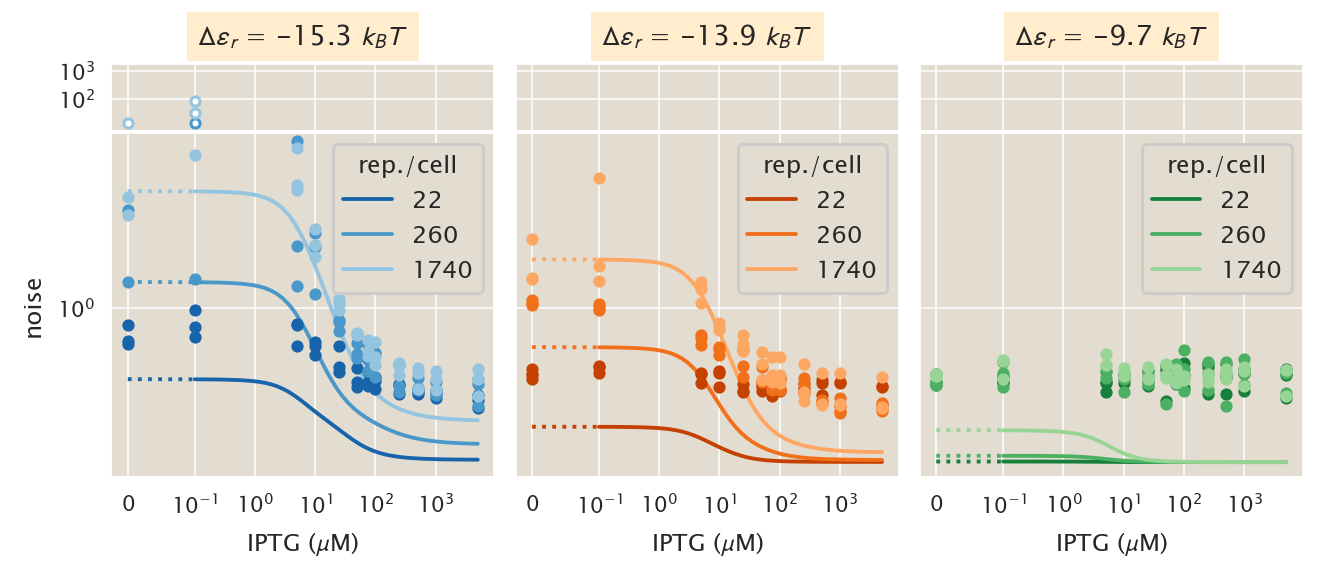

In [90]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[df_noise.noise > 0].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_mom_iptg[df_mom_iptg['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])
df_group_single = df_mom_single[df_mom_single['repressor'].\
                  isin(rep)].sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i],
                                 n_colors=len(rep) + 1)[0:3]))

# Define threshold to separate linear from log scale
thresh = 1E-1

# Initialize figure
fig, ax = plt.subplots(2, 3, figsize=(7, 2.5), sharex=True, sharey='row',
                       gridspec_kw={'height_ratios':[1, 5], 'wspace':0.05,
                                    'hspace': 0})
ax = ax.ravel()
# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Log scale
    ax[op_idx[group[0]] + 3].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                                  data[data.inducer_uM >= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    # Linear scale
    ax[op_idx[group[0]] + 3].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                                  data[data.inducer_uM <= thresh].p_noise, 
                                  color=col_dict[group[0]][group[1]],
                                  label='', linestyle=':')

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot data points on lower plot
    ax[op_idx[group[0]] + 3].plot(data[data.noise <= 10].IPTG_uM, 
                                  data[data.noise <= 10].noise,
                                  linestyle='--',
                                  color=col_dict[group[0]][group[1]],
                                  label='', lw=0, marker='o', markersize=3)
    # Plot same data points with different plotting style on the upper row
    ax[op_idx[group[0]]].plot(data[data.noise > 10].IPTG_uM, 
                              data[data.noise > 10].noise, 
                              linestyle='--', color='w', label='', lw=0,
                              marker='o', markersize=3,
                              markeredgecolor=col_dict[group[0]][group[1]])

# Set scales of reference plots and the other ones will follow
ax[0].set_xscale('symlog', linthreshx=thresh, linscalex=1)
ax[0].set_yscale('log')
ax[3].set_yscale('log')

# Set limits of reference plots and the rest will folow
ax[3].set_ylim(top=6)
ax[0].set_ylim([6, 2E3])

# Set ticks for the upper plot
ax[0].set_yticks([1E2, 1E3])

# Define location for secondary legend
leg2_loc = ['lower left'] * 2 + ['upper left']

for i in range(3):
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    # Label axis
    ax[i + 3].set_xlabel(r'IPTG ($\mu$M)')
    # Set legend
    leg = ax[i + 3].legend(title='rep./cell', fontsize=8)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=8)
ax[3].set_ylabel(r'noise')   

# Save figure
plt.savefig(figdir + 'noise_comparison_exp_scale.pdf', bbox_inches='tight')

Let's repeat the same plot, but this time showing the noise in linear scale for a range < 10.

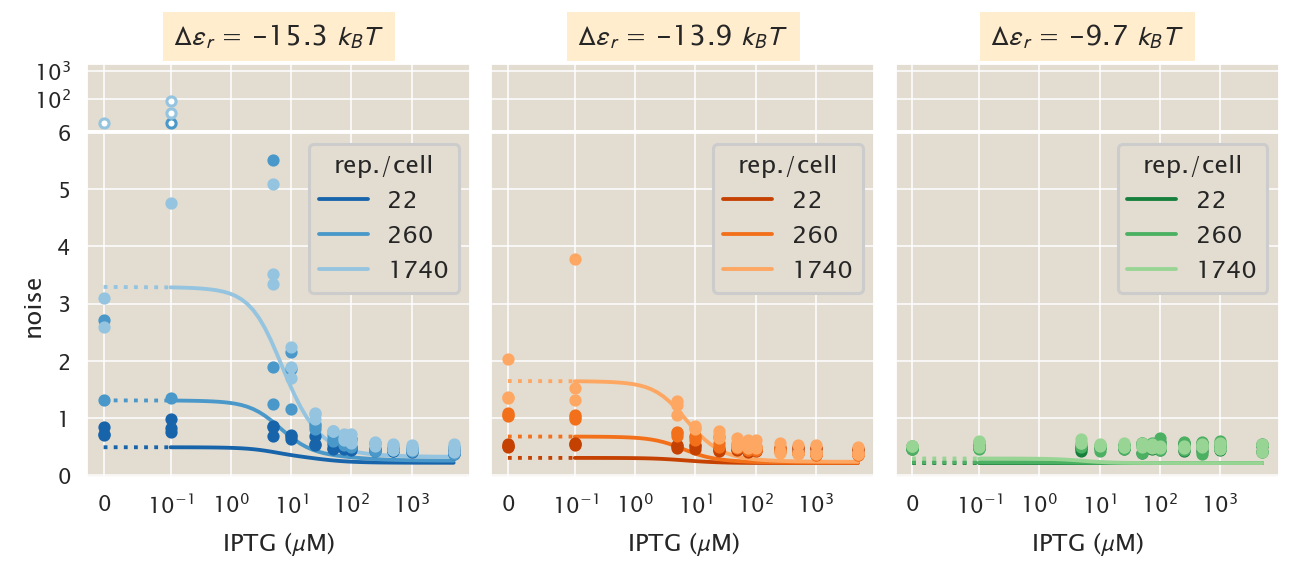

In [89]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[df_noise.noise > 0].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_mom_iptg[df_mom_iptg['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])
df_group_single = df_mom_single[df_mom_single['repressor'].\
                  isin(rep)].sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i],
                                 n_colors=len(rep) + 1)[0:3]))

# Define threshold to separate linear from log scale
thresh = 1E-1

# Initialize figure
fig, ax = plt.subplots(2, 3, figsize=(7, 2.5), sharex=True, sharey='row',
                       gridspec_kw={'height_ratios':[1, 5], 'wspace':0.05,
                                    'hspace': 0})
ax = ax.ravel()
# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Log scale
    ax[op_idx[group[0]] + 3].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                                  data[data.inducer_uM >= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    # Linear scale
    ax[op_idx[group[0]] + 3].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                                  data[data.inducer_uM <= thresh].p_noise, 
                                  color=col_dict[group[0]][group[1]],
                                  label='', linestyle=':')

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot data points on lower plot
    ax[op_idx[group[0]] + 3].plot(data[data.noise <= 10].IPTG_uM, 
                                  data[data.noise <= 10].noise,
                                  linestyle='--',
                                  color=col_dict[group[0]][group[1]],
                                  label='', lw=0, marker='o', markersize=3)
    # Plot same data points with different plotting style on the upper row
    ax[op_idx[group[0]]].plot(data[data.noise > 10].IPTG_uM, 
                              data[data.noise > 10].noise, 
                              linestyle='--', color='w', label='', lw=0,
                              marker='o', markersize=3,
                              markeredgecolor=col_dict[group[0]][group[1]])

# Set scales of reference plots and the other ones will follow
ax[0].set_xscale('symlog', linthreshx=thresh, linscalex=1)
ax[0].set_yscale('log')

# Set limits of reference plots and the rest will folow
ax[3].set_ylim(top=6)
ax[0].set_ylim([6, 2E3])

# Set ticks for the upper plot
ax[0].set_yticks([1E2, 1E3])

# Define location for secondary legend

for i in range(3):
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    # Label axis
    ax[i + 3].set_xlabel(r'IPTG ($\mu$M)')
    # Set legend
    leg = ax[i + 3].legend(title='rep./cell', fontsize=8)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=8)
ax[3].set_ylabel(r'noise')   

# Save figure
plt.savefig(figdir + 'noise_comparison_lin_scale.pdf', bbox_inches='tight')

### fold-change & noise side to side

Let's now look at the fold-change and the noise simultaneously to show that the theory can capture both the first and the second moment.

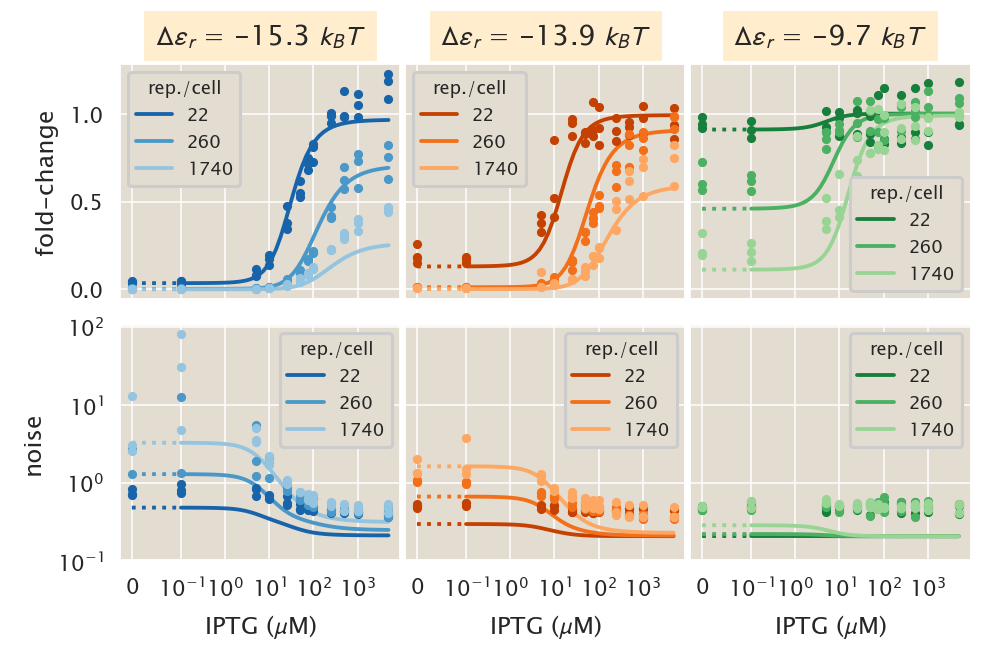

In [92]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[(df_noise.noise > 0)].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_mom_iptg[df_mom_iptg['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep,sns.color_palette(col_list[i], 
                                                  n_colors=len(rep) + 1)[0:3]))

# Define threshold to separate log scale from linear scale
thresh = 1E-1
# Initialize figure
fig, ax = plt.subplots(2, 3, figsize=(5, 3), sharex=True, sharey='row')

# Linearize plot numeration
ax = ax.ravel()

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Plot fold-change
    # Log scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                              data[data.inducer_uM >= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    # Linear scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                              data[data.inducer_uM <= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')
    
    # Plot noise
    # Log scale
    ax[op_idx[group[0]] + 3].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                                  data[data.inducer_uM >= thresh].p_noise, 
                                  color=col_dict[group[0]][group[1]],
                                  label=int(group[1]))
    # Linear scale
    ax[op_idx[group[0]] + 3].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                                  data[data.inducer_uM <= thresh].p_noise, 
                                  color=col_dict[group[0]][group[1]],
                                  label='', linestyle=':')

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot fold_change
    ax[op_idx[group[0]]].plot(data.IPTG_uM, data.fold_change, linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=2)
    # Plot noise
    ax[op_idx[group[0]] + 3].plot(data.IPTG_uM, data.noise, linestyle='--',
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=2)


for i, a in enumerate(ax):
    # systematically change axis for all subplots
    ax[i].set_xscale('symlog', linthreshx=thresh, linscalex=1)
    # Set specifics for fold-change plots
    if i < 3:
        # Set title
        label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                        format(energies[i])
        ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
        # Set legend on fold-change plot
        leg = ax[i].legend(title='rep./cell', fontsize=6)
        # Set legend font size
        plt.setp(leg.get_title(), fontsize=6)
        # Set legend on noise plot
        leg2 = ax[i + 3].legend(title='rep./cell', fontsize=6)
        # Set legend font size
        plt.setp(leg2.get_title(), fontsize=6)
        
    # Set specifics for noise plots
    else:
        ax[i].set_yscale('log')
        ax[i].set_ylim(bottom=1E-1)
        # Label axis
        ax[i].set_xlabel(r'IPTG ($\mu$M)')
    
ax[0].set_ylabel(r'fold-change')
ax[3].set_ylabel(r'noise')

# Change spacing between plots
plt.subplots_adjust(wspace=0.01, hspace=0.1)

plt.savefig(figdir + 'moment_comparison_exp.pdf', bbox_inches='tight')

Again let's change the scale of the lower row to emphasize less those outliers. This plot will require a lot of manipulation of `GridSpec` given the necessary separation between subplots.

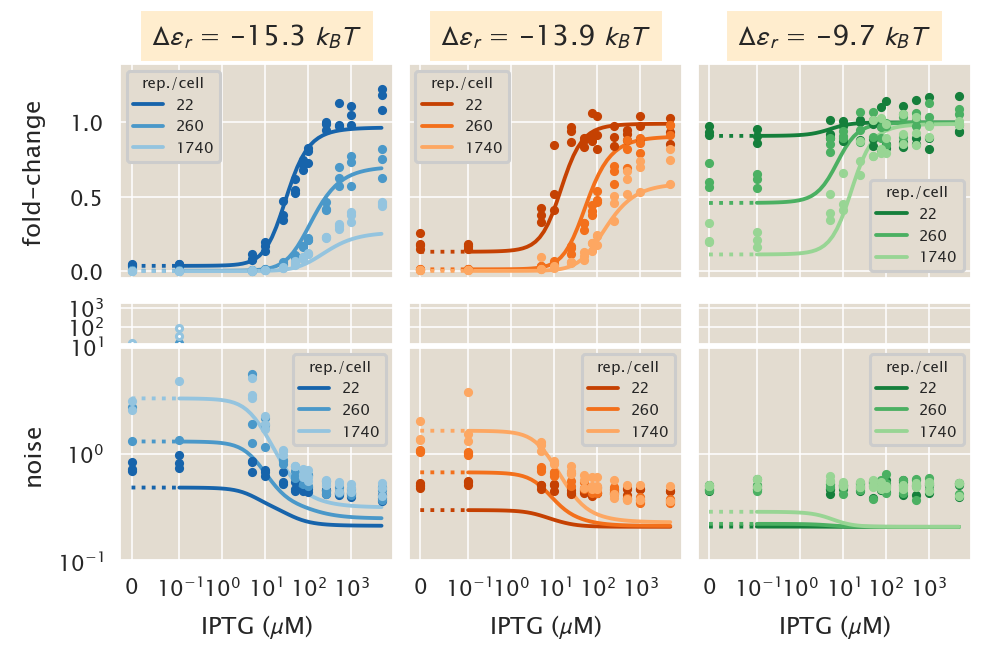

In [93]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[(df_noise.noise > 0)].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_mom_iptg[df_mom_iptg['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i],
                                 n_colors=len(rep) + 1)[0:3]))

# Set threshold to separate linear and logarithmic scale    
thresh = 1E-1

fig = plt.figure(figsize=(5, 3))
# Define outer grispec to keep at top the fold-change and at the bottom
# the noise
gs_out = mpl.gridspec.GridSpec(2, 1, height_ratios = [1, 1 + 1/5],
                               hspace=.1, wspace=0.05)

#make nested gridspecs
gs_fc = mpl.gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_out[0],
                                             wspace=0.05)
gs_noise = mpl.gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs_out[1],
                                                wspace=0.05, hspace=.01,
                                                height_ratios=[1, 5])

# Add axis to plots
# fold-change
ax_fc = [plt.subplot(gs) for gs in gs_fc]
# noise
ax_noise = [plt.subplot(gs) for gs in gs_noise]

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Plot fold-change
    # Linear
    ax_fc[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                                 data[data.inducer_uM <= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')
    # Log
    ax_fc[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                                 data[data.inducer_uM >= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    
    # Plot noise
    # Linear
    ax_noise[op_idx[group[0]] + 3].plot(data[data.inducer_uM <= 
                                             thresh].inducer_uM, 
                                        data[data.inducer_uM <=
                                             thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')
    # Log
    ax_noise[op_idx[group[0]] + 3].plot(data[data.inducer_uM >=
                                             thresh].inducer_uM, 
                                        data[data.inducer_uM >=
                                             thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot fold_change
    ax_fc[op_idx[group[0]]].plot(data.IPTG_uM, data.fold_change,
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=2)
    # Plot noise
    ax_noise[op_idx[group[0]] + 3].plot(data[data.noise <= 10].IPTG_uM, 
                                        data[data.noise <= 10].noise,
                                        color=col_dict[group[0]][group[1]],
                                        label='', lw=0, marker='o',
                                        markersize=2)
    # Plot noise
    ax_noise[op_idx[group[0]]].plot(data[data.noise > 10].IPTG_uM,
                               data[data.noise > 10].noise,
                               color='w',
                               markeredgecolor=col_dict[group[0]][group[1]],
                               label='', lw=0, marker='o',
                               markersize=2)

##  Set shared axis

# fold-change
# Loop through axis
for i in range(1, 3):
    # Select axis
    ax = ax_fc[i]
    # join axis with first plot
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    ax.get_shared_y_axes().join(ax, ax_fc[0])
    # Remove x and y ticks
    plt.setp(ax.get_xticklabels(), visible=False)   
    plt.setp(ax.get_yticklabels(), visible=False)   
# Remove x ticks from left plot
plt.setp(ax_fc[0].get_xticklabels(), visible=False)   
# Set axis to be shared with left lower plot
ax_fc[0].get_shared_x_axes().join(ax_fc[0], ax_noise[3])

# noise upper
# Loop through axis
for i in range(1, 3):
    # Select axis
    ax = ax_noise[i]
    # join x axis with lower left plot 
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    # join y axis with upper left plot 
    ax.get_shared_y_axes().join(ax, ax_noise[0])
    # Remove x and y ticks
    plt.setp(ax.get_xticklabels(), visible=False)   
    plt.setp(ax.get_yticklabels(), visible=False)   
# Set upper left plot x axis to be shared with lower left plot
ax.get_shared_x_axes().join(ax_noise[0], ax_noise[3])
# Remove x ticks from left plot
plt.setp(ax_noise[0].get_xticklabels(), visible=False)   

# noise lower 
# Loop through axis
for i in range(4, 6):
    # Select axis
    ax = ax_noise[i]
    # join axis with lower left plot 
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    ax.get_shared_y_axes().join(ax, ax_noise[3])
    # Remove y ticks labels
    plt.setp(ax.get_yticklabels(), visible=False)   

# Set scales of reference plots and the other ones will follow
ax_noise[3].set_xscale('symlog', linthreshx=thresh)#, linscalex=0.5)
ax_noise[0].set_yscale('log')
ax_noise[3].set_yscale('log')

# Set limits
for i in range(3):
    ax_fc[i].set_ylim([-0.05, 1.4])

ax_noise[0].set_ylim([1E1, 2E3])
ax_noise[3].set_ylim([1E-1, 1E1])

# Label axis
for i, ax in enumerate(ax_fc):
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                        format(energies[i])
    ax.set_title(label, bbox=dict(facecolor='#ffedce'))
    # Set legend
    leg = ax.legend(title='rep./cell', fontsize=5)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=5)
    leg2 = ax_noise[i + 3].legend(title='rep./cell', fontsize=5,
                                  loc='upper right')
    plt.setp(leg2.get_title(), fontsize=5)
    
    ax_noise[i + 3].set_xlabel(r'IPTG ($\mu$M)')
    
# Set ticks for the upper noise plot
ax_noise[0].set_yticks([1E2, 1E3])
ax_noise[1].set_yticks([1E2, 1E3])
ax_noise[2].set_yticks([1E2, 1E3])
   
# Add y axis labels    
ax_fc[0].set_ylabel(r'fold-change')
ax_noise[3].set_ylabel(r'noise')

# Align y axis labels
fig.align_ylabels()

plt.savefig(figdir + 'moment_comparison_exp_scale.pdf', bbox_inches='tight')
plt.savefig(figdir + 'moment_comparison_exp_scale.svg', bbox_inches='tight')

And finally a version of this plot with the noise in linear scale

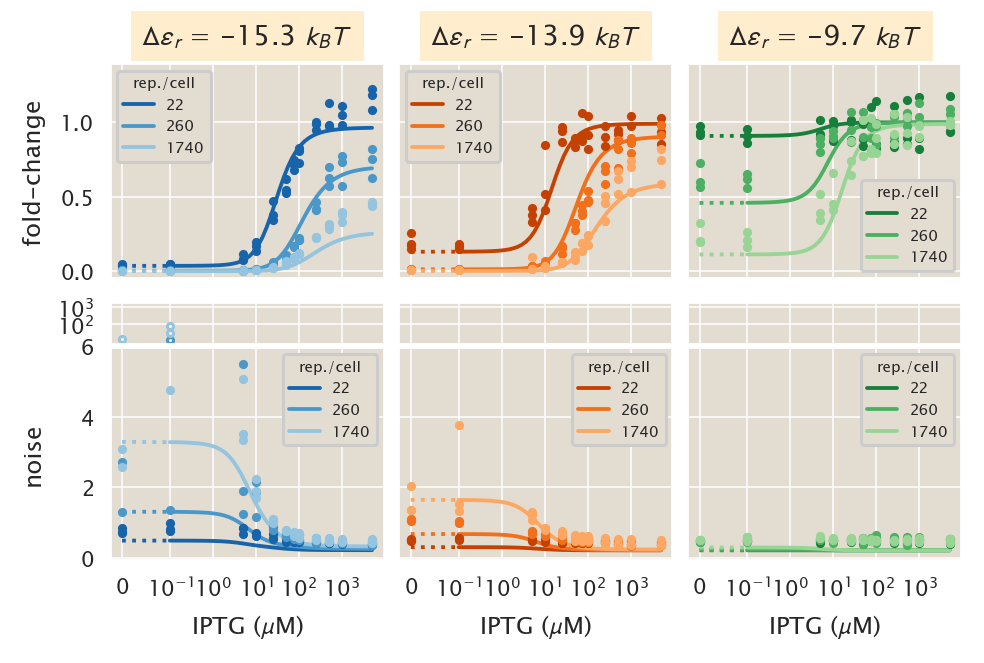

In [96]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[(df_noise.noise > 0)].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_mom_iptg[df_mom_iptg['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i],
                                 n_colors=len(rep) + 1)[0:3]))

# Set threshold to separate linear and logarithmic scale    
thresh = 1E-1

fig = plt.figure(figsize=(5, 3))
# Define outer grispec to keep at top the fold-change and at the bottom
# the noise
gs_out = mpl.gridspec.GridSpec(2, 1, height_ratios = [1, 1 + 1/5],
                               hspace=.1, wspace=0.05)

#make nested gridspecs
gs_fc = mpl.gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_out[0],
                                             wspace=0.05)
gs_noise = mpl.gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs_out[1],
                                                wspace=0.05, hspace=.01,
                                                height_ratios=[1, 5])

# Add axis to plots
# fold-change
ax_fc = [plt.subplot(gs) for gs in gs_fc]
# noise
ax_noise = [plt.subplot(gs) for gs in gs_noise]

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Plot fold-change
    # Linear
    ax_fc[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                                 data[data.inducer_uM <= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')
    # Log
    ax_fc[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                                 data[data.inducer_uM >= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    
    # Plot noise
    # Linear
    ax_noise[op_idx[group[0]] + 3].plot(data[data.inducer_uM <= 
                                             thresh].inducer_uM, 
                                        data[data.inducer_uM <=
                                             thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')
    # Log
    ax_noise[op_idx[group[0]] + 3].plot(data[data.inducer_uM >=
                                             thresh].inducer_uM, 
                                        data[data.inducer_uM >=
                                             thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot fold_change
    ax_fc[op_idx[group[0]]].plot(data.IPTG_uM, data.fold_change,
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=2)
    # Plot noise
    ax_noise[op_idx[group[0]] + 3].plot(data[data.noise <= 10].IPTG_uM, 
                                        data[data.noise <= 10].noise,
                                        color=col_dict[group[0]][group[1]],
                                        label='', lw=0, marker='o',
                                        markersize=2)
    # Plot noise
    ax_noise[op_idx[group[0]]].plot(data[data.noise > 10].IPTG_uM,
                               data[data.noise > 10].noise,
                               color='w',
                               markeredgecolor=col_dict[group[0]][group[1]],
                               label='', lw=0, marker='o',
                               markersize=2)

##  Set shared axis

# fold-change
# Loop through axis
for i in range(1, 3):
    # Select axis
    ax = ax_fc[i]
    # join axis with first plot
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    ax.get_shared_y_axes().join(ax, ax_fc[0])
    # Remove x and y ticks
    plt.setp(ax.get_xticklabels(), visible=False)   
    plt.setp(ax.get_yticklabels(), visible=False)   
# Remove x ticks from left plot
plt.setp(ax_fc[0].get_xticklabels(), visible=False)   
# Set axis to be shared with left lower plot
ax_fc[0].get_shared_x_axes().join(ax_fc[0], ax_noise[3])

# noise upper
# Loop through axis
for i in range(1, 3):
    # Select axis
    ax = ax_noise[i]
    # join x axis with lower left plot 
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    # join y axis with upper left plot 
    ax.get_shared_y_axes().join(ax, ax_noise[0])
    # Remove x and y ticks
    plt.setp(ax.get_xticklabels(), visible=False)   
    plt.setp(ax.get_yticklabels(), visible=False)   
# Set upper left plot x axis to be shared with lower left plot
ax.get_shared_x_axes().join(ax_noise[0], ax_noise[3])
# Remove x ticks from left plot
plt.setp(ax_noise[0].get_xticklabels(), visible=False)   

# noise lower 
# Loop through axis
for i in range(4, 6):
    # Select axis
    ax = ax_noise[i]
    # join axis with lower left plot 
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    ax.get_shared_y_axes().join(ax, ax_noise[3])
    # Remove y ticks labels
    plt.setp(ax.get_yticklabels(), visible=False)   

# Set scales of reference plots and the other ones will follow
ax_noise[3].set_xscale('symlog', linthreshx=thresh)#, linscalex=0.5)
ax_noise[0].set_yscale('log')

# Set limits
for i in range(3):
    ax_fc[i].set_ylim([-0.05, 1.4])

ax_noise[0].set_ylim([6, 2E3])
ax_noise[3].set_ylim([-0.1, 6])

# Label axis
for i, ax in enumerate(ax_fc):
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                        format(energies[i])
    ax.set_title(label, bbox=dict(facecolor='#ffedce'))
    # Set legend
    leg = ax.legend(title='rep./cell', fontsize=5)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=5)
    leg2 = ax_noise[i + 3].legend(title='rep./cell', fontsize=5,
                                  loc='upper right')
    plt.setp(leg2.get_title(), fontsize=5)
    
    ax_noise[i + 3].set_xlabel(r'IPTG ($\mu$M)')
    
# Set ticks for the upper noise plot
ax_noise[0].set_yticks([1E2, 1E3])
ax_noise[1].set_yticks([1E2, 1E3])
ax_noise[2].set_yticks([1E2, 1E3])
   
# Add y axis labels    
ax_fc[0].set_ylabel(r'fold-change')
ax_noise[3].set_ylabel(r'noise')

# Align y axis labels
fig.align_ylabels()

plt.savefig(figdir + 'moment_comparison_lin_scale.pdf', bbox_inches='tight')
plt.savefig(figdir + 'moment_comparison_lin_scale.svg', bbox_inches='tight')

---

## Increase the range of repressors

Let's compute all the moments of the distribution for a larger range of repressors.

In [101]:
# Define experimental concentrations in µM
inducer = [0, 0.1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000] # µM

# Define repressor copy numebers
repressors = np.logspace(0, 6, 200)
repressors = np.unique(repressors.round(0))

# Define operators and energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]
op_dict = dict(zip(operators, energies))

# Generate list of all operator, repressor and inducer concentrations
var =  [t for t in itertools.product(*[operators, repressors, inducer])]

Having defined the parameters, let's nos compute the moments.

In [103]:
# Boolean indicating if computation should be performed
compute_constraints = True

if compute_constraints:
    # Initialize data frame to save the lagrange multipliers.
    names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']
    names = names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in expo_reg]         

    # Initialize DataFrame to save constraints
    df_constraints = pd.DataFrame([], columns=names)


    # Define function for parallel computation
    def constraints_parallel(param):
        # Extract variables
        op = param[0]  #operator
        eRA = op_dict[op]  # binding energy
        rep = param[1]  # repressors
        iptg = param[2]  # inducer
        
        print(op, eRA, rep, iptg)
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * ccutils.model.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = ccutils.model.kr_off_fun(eRA, ko, kp_on, kp_off,
                                      Nns, Vcell)

        # Generate matrices for dynamics
        # Single promoter
        par_reg_s = [kr_on, kr_off, kp_on, kp_off, rm, gm, rp, 0]
        # Two promoters
        par_reg_d = [kr_on, kr_off, kp_on, kp_off, 2 * rm, gm, rp, 0]
        
        # Initial conditions
        A_reg_s_init = A_mat_reg_lam(kr_on, kr_off, kp_on, kp_off,
                                   rm, gm, rp_init, gp_init)
        
        # Define initial conditions
        mom_init = np.zeros(len(expo_reg) * 3)
        # Set initial condition for zero moment
        # Since this needs to add up to 1
        mom_init[0] = 1

        # Define time on which to perform integration
        t = np.linspace(0, 4000 * 60, 10000)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(dmomdt, mom_init, t, 
                                     args=(A_reg_s_init,))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]
        
        # Integrate moment equations
        df = dmomdt_cycles(m_init, t_single, t_double,
                           A_mat_reg_lam, 
                           par_reg_s, par_reg_d,
                           expo_reg, n_cycles, Z_mat,
                           states=['P', 'E', 'R'], 
                           n_steps=3000)
        
        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Initialize list to append moments
        moms = list()
        # Loop through moments computing the average moment
        for i, mom in enumerate(expo_reg):
            # Generate string that finds the moment
            mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
            # List rows with moment
            mom_bool = [x for x in df.columns if mom_name in x]
            # Extract data for this particular moment
            df_mom = df.loc[:, mom_bool].sum(axis=1)

            # Average moment and append it to list
            moms.append(sp.integrate.simps(df_mom * p_a_array,
                                           a_array))
                
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, rep, iptg] + moms,
                   index=names)
    
        return series
    
    # Run function in parallel
    constraint_series = Parallel(n_jobs=6)(delayed(constraints_parallel)(param)
                           for param in var)

    # Initialize data frame to save list of parameters
    df_constraints = pd.DataFrame([], columns=names)

    for s in constraint_series:
        df_constraints = df_constraints.append(s, ignore_index=True)

    # Save progress at each step
    df_constraints.to_csv(datadir + 'MaxEnt_constraints_mult_protein_ext_R.csv',
              index=False)

df_constraints = pd.read_csv(datadir + 'MaxEnt_constraints_mult_protein_ext_R.csv')
df_constraints.head()

,operator,binding_energy,repressor,inducer_uM,m0p0,m1p0,m2p0,m3p0,m4p0,m5p0,...,m3p2,m2p3,m1p4,m0p5,m5p1,m4p2,m3p3,m2p4,m1p5,m0p6
0,O1,-15.3,1.0,0.0,1.000003,7.400507,131.130403,3241.843771,100376.332578,3.670804e+06,...,6.723027e+10,1.195701e+13,2.778769e+15,1.250041e+18,1.714835e+10,2.208011e+12,3.323767e+14,6.041365e+16,1.425503e+19,6.333034e+21
1,O1,-15.3,1.0,0.1,1.000000,7.418869,131.567782,3254.265127,100793.930348,3.686944e+06,...,6.779911e+10,1.207937e+13,2.811082e+15,1.264604e+18,1.726346e+10,2.227338e+12,3.359226e+14,6.116224e+16,1.445092e+19,6.420238e+21
2,O1,-15.3,1.0,5.0,0.999999,10.411248,205.520413,5400.324818,174010.099135,6.547398e+06,...,2.101978e+11,4.778738e+13,1.350895e+16,6.097340e+18,4.194563e+10,7.148568e+12,1.399784e+15,3.226278e+17,9.194722e+19,4.102741e+22
3,O1,-15.3,1.0,10.0,1.000000,13.110175,275.437040,7484.765596,246424.070491,9.414049e+06,...,4.435670e+11,1.193820e+14,3.873027e+16,1.752808e+19,7.454564e+10,1.536696e+13,3.596819e+15,9.749913e+17,3.170802e+20,1.419782e+23
4,O1,-15.3,1.0,25.0,1.000000,15.504358,339.050460,9408.885817,313918.105187,1.210478e+07,...,7.548573e+11,2.298086e+14,8.254661e+16,3.743681e+19,1.117386e+11,2.644852e+13,7.044923e+15,2.148262e+18,7.698713e+20,3.456673e+23
